# Libraries

In [1]:
# Prior libraries
import pandas as pd
import numpy as np
import os
import string

# To Get Combinatiobs
import itertools

# Datetime Libraries
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
import time

# Trend Seasonality
from statsmodels.tsa.seasonal import STL

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SAS Connection Library
import swat

import warnings
warnings.filterwarnings("ignore")

C:\Users\tunahan.aktas\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\__init__.py:1: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from .axes3d import Axes3D


---

# Read Files

In [2]:
start_all_process = datetime.now()

In [3]:
start_time = datetime.now()

In [4]:
# List of Excel Files
btt_lst = sorted([doc_ for doc_ in os.listdir("../data") if doc_.startswith("Demand Sensing Sales History") or doc_.startswith("Demand_Sensing_Sales_")])
hor_lst = sorted([doc_ for doc_ in os.listdir("../data/08092021") if doc_.startswith("Horizon_Saha_") ])
pas_lst = sorted([doc_ for doc_ in os.listdir("../data/08092021") if doc_.startswith("Siparişe_göre_Sales_History")])
saha_aktivite_lst = sorted([doc_ for doc_ in os.listdir("../data") if doc_.startswith("Demand_Sensing_Saha_Aktivit") or doc_.startswith("Demand Sensing Saha Aktivit")])
pasifik_aktivite_lst = sorted([doc_ for doc_ in os.listdir("../data") if doc_.startswith("Pasifik Aktivite Datası")])
fiyat_lst = sorted([doc_ for doc_ in os.listdir("../data") if "Fiyat List" in doc_])
portfoy_lst = sorted([doc_ for doc_ in os.listdir("../data") if doc_.startswith("Portföy")])
eslenik_kod_lst = sorted([doc_ for doc_ in os.listdir("../data") if doc_.startswith("Ürün Eşlenik kodlar")])
kapsam_listeli = sorted([doc_ for doc_ in os.listdir("../data") if doc_.startswith("Listeli Ürün")])
pas_siparis_lst = sorted([doc_ for doc_ in os.listdir("../data/siparis") if doc_.startswith("Siparişe_göre_Sales_History")])

In [5]:
end_time = datetime.now()
print('Dosya Listelerini Okuma İşlemi: {}'.format(end_time - start_time))

Dosya Listelerini Okuma İşlemi: 0:00:00.018000


---
# Read Data
---

In [6]:
start_time = datetime.now()

# Historik data ve koli içi adetlerini okuyoruz

In [7]:
# Read Sales Data
pasifik_df_all = []
btt_df_all = []
horizon_saha_df_all = []
chng_cols_beginning = {'Year': 'Yıl', 'Quarter': 'Çeyrek', 'Month': 'Ay', 
                       'Company Code': 'Şirket Kodu', 'Main Category Name': 'Ana Kategori Adı', 
                       'Category Name': 'Kategori Adı', 'Brand Name': 'Marka Adı', 'Product Code': 'Ürün Kodu', 
                       'Product Name': 'Ürün Adı', "Ürün Adı (Mobis)": 'Ürün Adı'}
for docs_ in btt_lst:
    btt_df_all.append(pd.read_excel("../data/"+docs_, skiprows=1, sheet_name="BTT SAP Satış", usecols="B:N").rename(columns=chng_cols_beginning))

for docs_ in hor_lst:
    horizon_saha_df_all.append(pd.read_excel("../data/08092021/"+docs_, skiprows=1, sheet_name="Horizon Saha Satış", usecols="B:L").rename(columns=chng_cols_beginning))

for docs_ in pas_lst:
    pasifik_df_all.append(pd.read_excel("../data/08092021/"+docs_, sheet_name="Ürün Bazlı", usecols="B:O").rename(columns=chng_cols_beginning))

# Pasifik ve Horizon historic datasında koli içi adetini bir önceki versiyon olan excelin içerisinden okuyoruz. Bu yüzden siparis klasörünün içindeki dosyalarda gezeceğiz.
pasifik_df_koli_ici_adet = [] 
for docs_ in pas_siparis_lst:
    pasifik_df_koli_ici_adet.append(pd.read_excel("../data/siparis/"+docs_, skiprows=1, sheet_name="Koli içi adet", usecols="B:D").rename(columns=chng_cols_beginning))

horizon_df_eski = [] 
for docs_ in btt_lst:
    horizon_df_eski.append(pd.read_excel("../data/"+docs_, skiprows=1, sheet_name="Horizon Saha Satış", usecols="B:N").rename(columns=chng_cols_beginning))

pasifik_df_all = pd.concat(pasifik_df_all)
btt_df_all = pd.concat(btt_df_all)
horizon_saha_df_all = pd.concat(horizon_saha_df_all)

pasifik_df_koli_ici_adet = pd.concat(pasifik_df_koli_ici_adet)
horizon_df_eski = pd.concat(horizon_df_eski)

In [8]:
end_time = datetime.now()
print('Historik datanın Jupytere yüklenme süresi: {}'.format(end_time - start_time))

Historik datanın Jupytere yüklenme süresi: 0:05:44.469548


# Sadece Gerekli Sütunlar Tutuluyor

In [9]:
pasifik_df_all.drop(columns=["Organizasyon Kodu", "Grup Kodu.", "Pladis-Non Pladis"], axis=1, inplace=True)
horizon_saha_df_all.drop(columns=["Çeyrek"], axis=1, inplace=True)
btt_df_all.drop(columns=["Çeyrek", "Şirket Kodu"], axis=1, inplace=True)

btt_df_all["Grup Adı"] = "BTT"
pasifik_df_all.rename(columns={"Ana Kategori": "Ana Kategori Adı", "Kategori": "Kategori Adı", "Ürün Adı (Orjinal)": "Ürün Adı", "Sipariş Miktarı(Dönüş. Koli)": "Koli", 
                               "Sipariş Brüt Tutar": "KG", "Sipariş Brüt KG": "TL"}, inplace=True)

horizon_saha_df_all.rename(columns={"Horizon müşteri grup": "Grup Adı", "Ürün Adı (Orjinal)": "Ürün Adı"}, inplace=True)

# Pasifik için koli içi adetler "Koli içi adet" sheetinde tutuluyor. Buradan alıyoruz fakat historik datada bulunmayan ürün kodları da var. Bu ürün kodlarından bazıları alfabetik harfler içeriyor. Bu durumu ortadan kaldırmak için aşağıdaki işlemi uyguluyoruz. 

## Pasifik Kısmı

In [10]:
col_order = ['Yıl', 'Ay', 'Grup Adı', 'Ana Kategori Adı', 'Kategori Adı', 'Marka Adı', 'Ürün Kodu', 'Ürün Adı', 'Koli İçi Adet', 'Koli', 'KG', 'TL']
ltrs = list(string.ascii_letters) # Alfabede bulunan tüm harfleri tutan liste. Bunu, koli içi adet dataframe'deki harf içeren ürün kodlarını elemek için tutuyoruz.

In [11]:
pasifik_df_koli_ici_adet.drop_duplicates(subset=pasifik_df_koli_ici_adet.columns.to_list(), keep="first", ignore_index=True, inplace=True) # Her dosyada 300k'ya yakın satır var. Yaklaşık 2M kadar satır geliyor çünkü 5-6 yıllık data okuyoruz. Bu yüzden drop duplicates ile satır sayısını azaltıyoruz.
pasifik_df_koli_ici_adet = pasifik_df_koli_ici_adet[~(pasifik_df_koli_ici_adet["Ürün Kodu"].str.contains("|".join(ltrs), regex=True))] # Alfabetik harflerle başlayan ürün kodlarını elemine ediyoruz.

pasifik_df_koli_ici_adet["Ürün Kodu"] = pasifik_df_koli_ici_adet["Ürün Kodu"].str.replace(" ", "") # Bazı ürün kodları 0015 01 şeklinde gelmiş. Yani nümerik gözükse de arada boşluk var. O yüzden boşlukları kaldırıyoruz.
pasifik_df_koli_ici_adet["Ürün Kodu"] = pasifik_df_koli_ici_adet["Ürün Kodu"].astype("int64") # Bir üst satırda boşlukları kaldırdıktan sonra integer hale getiriyoruz.
pasifik_df_koli_ici_adet = pasifik_df_koli_ici_adet[["Ürün Kodu", "Koli İçi Adet"]] # Bu iki satır kalabilir. Left join ile historik dataya ekleyeceğiz.

In [12]:
pasifik_df_all = pasifik_df_all.merge(pasifik_df_koli_ici_adet, on="Ürün Kodu", how="left")

## Horizon Kısmı

In [13]:
# Her dosyada; Ürün Adı sütununda "sum:" diye bir gözlem bulunuyor. Dip toplam yapıp datayı atmışlar. Bu satırları sildim.
horizon_saha_df_all = horizon_saha_df_all[~(horizon_saha_df_all["Ürün Adı"].str.contains("Sum:|sum:"))].reset_index(drop=True)

In [14]:
horizon_kategori = horizon_df_eski[['Ürün Kodu','Kategori Adı']]
horizon_kategori.drop_duplicates(inplace=True, ignore_index=True)

horizon_df_koli_ici_adet = horizon_df_eski[['Yıl','Ay','Ürün Kodu','Koli İçi Adet']]
horizon_df_koli_ici_adet.drop_duplicates(inplace=True, ignore_index=True)

In [15]:
horizon_saha_df_all = horizon_saha_df_all.merge(horizon_kategori, how='left', on='Ürün Kodu')
horizon_saha_df_all = horizon_saha_df_all.merge(horizon_df_koli_ici_adet, how='left')

In [16]:
pasifik_df_all = pasifik_df_all[col_order]
horizon_saha_df_all = horizon_saha_df_all[col_order]
btt_df_all = btt_df_all[col_order]

In [17]:
start_time = datetime.now()

In [18]:
# Read Saha Aktiviteleri
saha_aktivite_detay = []
saha_aktivite_cat = []

for docs_ in saha_aktivite_lst:
    saha_aktivite_detay.append(pd.read_excel("../data/"+docs_, skiprows=1, sheet_name="Ürün Detay", usecols="B:M"))
    saha_aktivite_cat.append(pd.read_excel("../data/"+docs_, skiprows=1, sheet_name="Kategori", usecols="B:I"))
saha_aktivite_detay = pd.concat(saha_aktivite_detay)
saha_aktivite_cat = pd.concat(saha_aktivite_cat)

In [19]:
# Read Pasifik Aktiviteleri
pasifik_aktivite_df = pd.read_excel("../data/"+pasifik_aktivite_lst[0])

In [20]:
# Read Fiyat Listesi
fiyat_lst_pasifik = pd.read_excel("../data/"+fiyat_lst[0])
fiyat_lst_horizon = pd.read_excel("../data/"+fiyat_lst[1])

In [21]:
# Read Portföy
pasifik_portfoy_df = pd.read_excel("../data/"+portfoy_lst[0], sheet_name="Pasifik Portföy", skiprows=3, usecols="D:H")
btt_portfoy_df = pd.read_excel("../data/"+portfoy_lst[0], sheet_name="BTT Portföy", skiprows=2, usecols="D:H")
horizon_portfoy_df = pd.read_excel("../data/"+portfoy_lst[0], sheet_name="Horizon Portföy", skiprows=2, usecols="E:I")

In [22]:
# Read Eşlenik Kodları
eslenik_kod_df = pd.read_excel("../data/"+eslenik_kod_lst[0])

In [23]:
# Read Calender
calender_df = pd.read_excel("../data/Calender_Monthly.xlsx")

In [24]:
# Read Plasiyer Yarışma
yarisma_df = pd.read_excel("../data/2018-2021 Yarışmaları_v2.xlsx", sheet_name="yarisma_historik_data")

In [25]:
eslenik_kod_df["En Güncel Kod"] = eslenik_kod_df["En Güncel Kod"].apply(lambda x: int(x) if x not in ['delist ', "delist"] else x.replace(" ", ""))

In [26]:
a101_kapsam = pd.read_excel("../data/"+kapsam_listeli[0], sheet_name="A101 Portföy")
sok_kapsam = pd.read_excel("../data/"+kapsam_listeli[0], sheet_name="Şok Portföy")
bim_kapsam = pd.read_excel("../data/"+kapsam_listeli[0], sheet_name="Bim Portföy")

a101_kapsam["grup_adi"] = "A101"
sok_kapsam["grup_adi"] = "ŞOK"
bim_kapsam["grup_adi"] = "BİM"

kapsam_all = pd.concat([a101_kapsam, sok_kapsam, bim_kapsam], axis=0, ignore_index=True)

In [27]:
# Read Enflasyon
enflasyon_df = pd.read_excel("../data/enflasyon.xlsx")

In [28]:
end_time = datetime.now()
print('Diğer dataların Jupytere yüklenme süresi: {}'.format(end_time - start_time))

Diğer dataların Jupytere yüklenme süresi: 0:00:41.588470


---
# Pasifik 2016 aktivite verileri olmadığı için 2016 Sales dataları çıkartıldı.

In [29]:
pasifik_df_all = pasifik_df_all[pasifik_df_all["Yıl"] != 2016].reset_index(drop=True)
pasifik_df_all = pasifik_df_all[~((pasifik_df_all["Yıl"] == 2021) & (pasifik_df_all["Ay"].isin([6, 7, 8, 9])))].reset_index(drop=True)
horizon_saha_df_all = horizon_saha_df_all[~((horizon_saha_df_all["Yıl"] == 2021) & (horizon_saha_df_all["Ay"].isin([6, 7, 8, 9])))].reset_index(drop=True)
btt_df_all = btt_df_all[~((btt_df_all["Yıl"] == 2021) & (btt_df_all["Ay"].isin([6, 7, 8, 9])))].reset_index(drop=True)

In [30]:
horizon_saha_df_all["Yıl"] = horizon_saha_df_all["Yıl"].astype(int)
horizon_saha_df_all["Ay"] = horizon_saha_df_all["Ay"].astype(int)

---

# Sales Datası İçin Ürün Kod Eşleme

---

---

## Join

In [31]:
kategori_adi = btt_df_all.drop_duplicates(subset=["Marka Adı", "Kategori Adı"], keep="first")[["Marka Adı", "Kategori Adı"]]
kategori_adi.sort_values(by=["Marka Adı", "Kategori Adı"], ignore_index=True, inplace=True)
kategori_adi = dict(kategori_adi.values)

In [32]:
horizon_saha_df_all["Kategori Adı"] = horizon_saha_df_all["Kategori Adı"].fillna(horizon_saha_df_all["Marka Adı"].map(kategori_adi))

In [33]:
pasifik_df_all.shape, horizon_saha_df_all.shape, btt_df_all.shape

((50063, 12), (308452, 12), (17353, 12))

In [34]:
pasifik_df_all = pd.merge(pasifik_df_all, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
horizon_saha_df_all = pd.merge(horizon_saha_df_all, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
btt_df_all = pd.merge(btt_df_all, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")

In [35]:
pasifik_df_all.shape, horizon_saha_df_all.shape, btt_df_all.shape

((50063, 13), (308452, 13), (17353, 13))

## Ürün Eşleme Kodları dosyasında yer almayan kodlar için mevcut ürün kodları verildi.

In [36]:
empty_ = pasifik_df_all[pd.isnull(pasifik_df_all["En Güncel Kod"])].reset_index(drop=True)
full_ = pasifik_df_all[~pd.isnull(pasifik_df_all["En Güncel Kod"])].reset_index(drop=True)
empty_["En Güncel Kod"] = empty_["Ürün Kodu"]
pasifik_df_all = pd.concat([empty_, full_], axis=0, ignore_index=True)
pasifik_df_all = pasifik_df_all.sort_values(pasifik_df_all.columns.to_list()).reset_index(drop=True)

empty_ = btt_df_all[pd.isnull(btt_df_all["En Güncel Kod"])].reset_index(drop=True)
full_ = btt_df_all[~pd.isnull(btt_df_all["En Güncel Kod"])].reset_index(drop=True)
empty_["En Güncel Kod"] = empty_["Ürün Kodu"]
btt_df_all = pd.concat([empty_, full_], axis=0, ignore_index=True)
btt_df_all = btt_df_all.sort_values(btt_df_all.columns.to_list()).reset_index(drop=True)

empty_ = horizon_saha_df_all[pd.isnull(horizon_saha_df_all["En Güncel Kod"])].reset_index(drop=True)
full_ = horizon_saha_df_all[~pd.isnull(horizon_saha_df_all["En Güncel Kod"])].reset_index(drop=True)
empty_["En Güncel Kod"] = empty_["Ürün Kodu"]
horizon_saha_df_all = pd.concat([empty_, full_], axis=0, ignore_index=True)
horizon_saha_df_all = horizon_saha_df_all.sort_values(horizon_saha_df_all.columns.to_list()).reset_index(drop=True)

## Adet adında yeni bir kolon oluşturuldu.

In [37]:
pasifik_df_all["Adet"] = pasifik_df_all["Koli İçi Adet"] * pasifik_df_all["Koli"]
btt_df_all["Adet"] = btt_df_all["Koli İçi Adet"] * btt_df_all["Koli"]
horizon_saha_df_all["Adet"] = horizon_saha_df_all["Koli İçi Adet"] * horizon_saha_df_all["Koli"]

In [38]:
pasifik_df_all.shape, horizon_saha_df_all.shape, btt_df_all.shape

((50063, 14), (308452, 14), (17353, 14))

## Delist olan ürünler veriden çıkartıldı.

In [39]:
pasifik_df_all = pasifik_df_all[pasifik_df_all["En Güncel Kod"] != "delist"].reset_index(drop=True)
btt_df_all = btt_df_all[btt_df_all["En Güncel Kod"] != "delist"].reset_index(drop=True)
horizon_saha_df_all = horizon_saha_df_all[horizon_saha_df_all["En Güncel Kod"] != "delist"].reset_index(drop=True)

In [40]:
pasifik_df_all.shape, horizon_saha_df_all.shape, btt_df_all.shape

((41432, 14), (266548, 14), (14582, 14))

## Aynı yıl, ay, grup adı, ana kategori adı, kategori adı, marka adı ve SKU kodundaki ürünler için toplam alındı. Sadece Koli İçi Adet için maksimum olan alındı.

---

# Marka adı dahil değil groupby'a
---

In [41]:
dct_to_sum = {"Koli İçi Adet": "sum", "Koli": "sum", "KG": "sum", "TL": "sum", "Adet": "sum"}

pasifik_df_all2 = pasifik_df_all.groupby(["Yıl", "Ay", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "En Güncel Kod"]).agg(dct_to_sum).reset_index()
btt_df_all2 = btt_df_all.groupby(["Yıl", "Ay", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "En Güncel Kod"]).agg(dct_to_sum).reset_index()
horizon_saha_df_all2 = horizon_saha_df_all.groupby(["Yıl", "Ay", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "En Güncel Kod"]).agg(dct_to_sum).reset_index()

In [42]:
pasifik_df_all2["Date"] = pasifik_df_all2["Yıl"].astype(str) + "-" +  pasifik_df_all2["Ay"].astype(str) + "-01"
btt_df_all2["Date"] = btt_df_all2["Yıl"].astype(int).astype(str) + "-" +  btt_df_all2["Ay"].astype(int).astype(str) + "-01"
horizon_saha_df_all2["Date"] = horizon_saha_df_all2["Yıl"].astype(int).astype(str) + "-" +  horizon_saha_df_all2["Ay"].astype(int).astype(str) + "-01"

pasifik_df_all2["Date"] = pd.to_datetime(pasifik_df_all2["Date"], format="%Y-%m-%d", errors="coerce")
btt_df_all2["Date"] = pd.to_datetime(btt_df_all2["Date"], format="%Y-%m-%d", errors="coerce")
horizon_saha_df_all2["Date"] = pd.to_datetime(horizon_saha_df_all2["Date"], format="%Y-%m-%d", errors="coerce")

## Horizon ve Pasifikte bulunan "Diğer"'lerin yanlarına "_" ile Diğer_Pasifik, Diğer_Horizon yazıldı.

In [43]:
pasifik_df_all2["Grup Adı"] = pasifik_df_all2["Grup Adı"].apply(lambda x: "Diğer_Pasifik" if x == "Diğer" else x)
horizon_saha_df_all2["Grup Adı"] = horizon_saha_df_all2["Grup Adı"].apply(lambda x: "Diğer_Horizon" if x == "Diğer" else x)
df_all2 = pd.concat([pasifik_df_all2, horizon_saha_df_all2, btt_df_all2], ignore_index=True)

---
# Pasifik Filling Missing Values
---

In [44]:
start_time = datetime.now()

In [45]:
pasifik_urun_isimleri = pasifik_df_all[["Marka Adı", "Ürün Adı", "En Güncel Kod"]].drop_duplicates(subset=["Marka Adı", "En Güncel Kod"],ignore_index=True,keep="first")
pasifik_urun_isimleri = pasifik_urun_isimleri[~((pasifik_urun_isimleri["Marka Adı"] == "DANKEK BATON") & (pasifik_urun_isimleri["En Güncel Kod"] == 80403))]
pasifik_df_all2 = pd.merge(pasifik_df_all2, pasifik_urun_isimleri[["En Güncel Kod", "Marka Adı", "Ürün Adı"]].drop_duplicates(subset=["En Güncel Kod", "Marka Adı", "Ürün Adı"], keep="first"), on="En Güncel Kod", how="left")
pasifik_df_all2 = pasifik_df_all2[pasifik_df_all2.columns.to_list()[:5]+pasifik_df_all2.columns.to_list()[-2:]+[pasifik_df_all2.columns.to_list()[5]]+pasifik_df_all2.columns.to_list()[6:12]]



horizon_urun_isimleri = horizon_saha_df_all[["Marka Adı", "Ürün Adı", "En Güncel Kod"]].drop_duplicates(subset=["Marka Adı", "En Güncel Kod"],ignore_index=True,keep="first")
horizon_urun_isimleri = horizon_urun_isimleri[~(((horizon_urun_isimleri["Marka Adı"] == "DANKEK BATON") & (horizon_urun_isimleri["En Güncel Kod"] == 80403)) | 
                                                ((horizon_urun_isimleri["Marka Adı"] == "MAVİ YEŞİL") & (horizon_urun_isimleri["En Güncel Kod"] == 11802)) |
                                                ((horizon_urun_isimleri["Marka Adı"] == "MAVİ YEŞİL") & (horizon_urun_isimleri["En Güncel Kod"] == 74306)) |
                                                ((horizon_urun_isimleri["Marka Adı"] == "AS KRAKER") & (horizon_urun_isimleri["En Güncel Kod"] == 190502)))]
horizon_saha_df_all2 = pd.merge(horizon_saha_df_all2, horizon_urun_isimleri[["En Güncel Kod", "Marka Adı", "Ürün Adı"]], on="En Güncel Kod", how="left")
horizon_saha_df_all2 = horizon_saha_df_all2[horizon_saha_df_all2.columns.to_list()[:5]+horizon_saha_df_all2.columns.to_list()[-2:]+[horizon_saha_df_all2.columns.to_list()[5]]+horizon_saha_df_all2.columns.to_list()[6:12]]



btt_urun_isimleri = btt_df_all[["Marka Adı", "Ürün Adı", "En Güncel Kod"]].drop_duplicates(subset=["Marka Adı", "En Güncel Kod"],ignore_index=True,keep="first")
btt_urun_isimleri = btt_urun_isimleri[~((btt_urun_isimleri["Marka Adı"] == "DANKEK BATON") & (btt_urun_isimleri["En Güncel Kod"] == 80403))]
btt_df_all2 = pd.merge(btt_df_all2, btt_urun_isimleri[["En Güncel Kod", "Marka Adı", "Ürün Adı"]].drop_duplicates(subset=["En Güncel Kod", "Marka Adı", "Ürün Adı"], keep="first"), on="En Güncel Kod", how="left")
btt_df_all2 = btt_df_all2[btt_df_all2.columns.to_list()[:5]+btt_df_all2.columns.to_list()[-2:]+[btt_df_all2.columns.to_list()[5]]+btt_df_all2.columns.to_list()[6:12]]

In [46]:
pasifik_df_all_filled = []
for idx, test in pasifik_df_all2.groupby(["En Güncel Kod", "Yıl", "Grup Adı"]):
    test.reset_index(drop=True, inplace=True)
    for i in range(1, 13):
        try:
            if i == test.loc[i-1, "Ay"]:
                if i == 13:
                    break
            else:
                test.loc[-1] = test.loc[0]
                test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
                test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
                test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        except:
            test.loc[-1] = test.loc[0]
            test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
            test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
            test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d", errors="coerce")
    rows_to_drop = []
    start = test.index[0]
    length = 1
    while (test.loc[start, "Adet"] == 1) and (length < len(test)):
        rows_to_drop.append(start)
        length+=1
        start+=1
    test.drop(index=rows_to_drop, inplace=True)
    pasifik_df_all_filled.append(test)

In [47]:
pasifik_df_all2 = pd.concat(pasifik_df_all_filled, ignore_index=True)

In [48]:
end_time = datetime.now()
print('Pasifik missing value düzenlenmesi süresi: {}'.format(end_time - start_time))

Pasifik missing value düzenlenmesi süresi: 0:02:56.847765


---
# Horizon Filling Missing Values
---

In [49]:
start_time = datetime.now()

In [50]:
horizon_saha_df_all_filled = []
for idx, test in horizon_saha_df_all2.groupby(["En Güncel Kod", "Yıl", "Grup Adı"]):
    test.reset_index(drop=True, inplace=True)
    for i in range(1, 13):
        try:
            if i == test.loc[i-1, "Ay"]:
                if i == 13:
                    break
            else:
                test.loc[-1] = test.loc[0]
                test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
                test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
                test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        except:
            test.loc[-1] = test.loc[0]
            test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
            test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
            test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d", errors="coerce")
    
    rows_to_drop = []
    start = test.index[0]
    length = 1
    while (test.loc[start, "Adet"] == 1) and (length < len(test)):
        rows_to_drop.append(start)
        length+=1
        start+=1
    test.drop(index=rows_to_drop, inplace=True)
    horizon_saha_df_all_filled.append(test)

In [51]:
horizon_saha_df_all2 = pd.concat(horizon_saha_df_all_filled, ignore_index=True)

In [52]:
end_time = datetime.now()
print('Horizon missing value düzenlenmesi süresi: {}'.format(end_time - start_time))

Horizon missing value düzenlenmesi süresi: 0:07:15.011427


---
# BTT Filling Missing Values
---

In [53]:
start_time = datetime.now()

In [54]:
btt_df_all_filled = []
for idx, test in btt_df_all2.groupby(["En Güncel Kod", "Yıl", "Grup Adı"]):
    test.reset_index(drop=True, inplace=True)
    for i in range(1, 13):
        try:
            if i == test.loc[i-1, "Ay"]:
                if i == 13:
                    break
            else:
                test.loc[-1] = test.loc[0]
                test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
                test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
                test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        except:
            test.loc[-1] = test.loc[0]
            test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
            test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
            test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d", errors="coerce")

    rows_to_drop = []
    start = test.index[0]
    length = 1
    while (test.loc[start, "Adet"] == 1) and (length < len(test)):
        rows_to_drop.append(start)
        length+=1
        start+=1
    test.drop(index=rows_to_drop, inplace=True)
    btt_df_all_filled.append(test)

In [55]:
btt_df_all2 = pd.concat(btt_df_all_filled, ignore_index=True)

In [56]:
end_time = datetime.now()
print('BTT missing value düzenlenmesi süresi: {}'.format(end_time - start_time))

BTT missing value düzenlenmesi süresi: 0:00:37.212344


---

# Aktivite Datası İçin Ürün Kod Eşleme

---

# Pasifik Aktivite

## Left join ile güncel kodlar getirildi. Delist olan ürünler listeden çıkartıldı. "Çeyrek" sütunu silindi. En güncel kod sütunnuda bulunamayan değerler Ürün Kodu sütunundan çekildi.

In [57]:
pasifik_aktivite_df2 = pd.merge(pasifik_aktivite_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
pasifik_aktivite_df2 = pasifik_aktivite_df2[pasifik_aktivite_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
pasifik_aktivite_df2.drop("Çeyrek", inplace=True, axis=1)
pasifik_aktivite_df2['En Güncel Kod'] = pasifik_aktivite_df2['En Güncel Kod'].fillna(pasifik_aktivite_df2['Ürün Kodu'])
pasifik_aktivite_df2.drop(columns="Ürün Kodu", axis=1, inplace=True)

---

# Pasifik Aktivite Ciro - Promosyon Tutarı ve İskonto Tekilleştirme (ORTALAMA ALARAK)

In [58]:
ort_pas = {"Raf Tavsiye Satış Fiyatı": "mean", "İndirimli Raf Satış Fiyatı": "mean", "İndirim %": "mean", "Aktivite Tipi": "first"}
pasifik_aktivite_df3 = pasifik_aktivite_df2.groupby(["En Güncel Kod", "Yıl", "Ay", "Müşteri Grup"]).agg(ort_pas).reset_index()
pasifik_aktivite_df3 = pd.merge(pasifik_aktivite_df3, pasifik_aktivite_df2[["Yıl", "Ay", "Müşteri Grup", "En Güncel Kod", 
                                                                            "Ana Kategori Adı", "Kategori Adı", "Marka Adı"]],
                                how="left", 
                                on=["En Güncel Kod", "Yıl", "Ay", "Müşteri Grup"])

pasifik_aktivite_df3.drop_duplicates(subset=pasifik_aktivite_df3.columns.to_list(), inplace=True)
pasifik_aktivite_df3.reset_index(drop=True, inplace=True)
pasifik_aktivite_df3 = pasifik_aktivite_df3[pasifik_aktivite_df2.drop("Ürün Adı", axis=1).columns.to_list()]

---

# Horizon Aktivite

In [59]:
saha_aktivite_detay2 = pd.merge(saha_aktivite_detay, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
saha_aktivite_detay2 = saha_aktivite_detay2[saha_aktivite_detay2["En Güncel Kod"] != "delist"].reset_index(drop=True)
saha_aktivite_detay2.drop("Çeyrek", inplace=True, axis=1)
saha_aktivite_detay2['En Güncel Kod'] = saha_aktivite_detay2['En Güncel Kod'].fillna(saha_aktivite_detay2['Ürün Kodu'])
saha_aktivite_detay2.drop(columns="Ürün Kodu", axis=1, inplace=True)
saha_aktivite_detay2["İskonto %"].replace("#DIV/0", np.nan,inplace=True)

# Horizon Aktivite Ciro - Promosyon Tutarı ve İskonto Tekilleştirme (ORTALAMA ALARAK)

In [60]:
ort = {"Ciro (Kull. İade Düş.)": "mean", "Promosyon Tutarı": "mean", "İskonto %": "mean"}
saha_aktivite_detay3 = saha_aktivite_detay2.groupby(["En Güncel Kod", "Yıl", "Ay", "Saha Müşteri Grup"]).agg(ort).reset_index()

saha_aktivite_detay3 = pd.merge(saha_aktivite_detay3, saha_aktivite_detay2[["Yıl", "Ay", "Saha Müşteri Grup", "En Güncel Kod", 
                                                 "Ana Kategori Adı", "Kategori Adı", "Marka Adı"]],
                           how="left", 
                           on=["En Güncel Kod", "Yıl", "Ay", "Saha Müşteri Grup"])

saha_aktivite_detay3.drop_duplicates(subset=saha_aktivite_detay3.columns.to_list(), inplace=True)

In [61]:
saha_aktivite_detay3 = saha_aktivite_detay3[saha_aktivite_detay2.drop("Ürün Adı (Mobis)", axis=1).columns.to_list()].reset_index(drop=True)

In [62]:
saha_aktivite_detay3.rename(columns={"Saha Müşteri Grup": "Grup Adı"}, inplace=True)
saha_aktivite_detay3["Grup Adı"] = saha_aktivite_detay3["Grup Adı"].apply(lambda x: "Diğer_Horizon" if x == "Diğer" else x)

---

# Fiyat Listesi

## Horizon Fiyatları
---

In [63]:
start_time = datetime.now()

In [64]:
fiyat_lst_horizon.drop_duplicates(subset=fiyat_lst_horizon.columns.to_list(), keep="first", ignore_index=True, inplace=True)

In [65]:
try:
    fiyat_lst_horizon["Malzeme"] = fiyat_lst_horizon["Malzeme"].str.replace("-", "")
    fiyat_lst_horizon["Malzeme"] = fiyat_lst_horizon["Malzeme"].astype(int)*1
except:
    fiyat_lst_horizon["Malzeme"] = fiyat_lst_horizon["Malzeme"].astype(int)*1

In [66]:
fiyat_lst_horizon_df = fiyat_lst_horizon.copy()

In [67]:
fiyat_lst_horizon_df["Baslangic_Yıl"] = fiyat_lst_horizon_df["Bşl.tarihi"].apply(lambda x: x.year)
fiyat_lst_horizon_df["Baslangic_Ay"] = fiyat_lst_horizon_df["Bşl.tarihi"].apply(lambda x: x.month)
fiyat_lst_horizon_df["Baslangic_Gun"] = fiyat_lst_horizon_df["Bşl.tarihi"].apply(lambda x: x.day)
fiyat_lst_horizon_df["Gecerlilik_Yıl"] = fiyat_lst_horizon_df["Gçrl.sonu"].apply(lambda x: x.year)
fiyat_lst_horizon_df["Gecerlilik_Ay"] = fiyat_lst_horizon_df["Gçrl.sonu"].apply(lambda x: x.month)
fiyat_lst_horizon_df["Gecerlilik_Gun"] = fiyat_lst_horizon_df["Gçrl.sonu"].apply(lambda x: x.day)

In [68]:
fiyat_lst_horizon_df["Baslangic_Yıl"] = fiyat_lst_horizon_df["Baslangic_Yıl"].apply(lambda x: (horizon_saha_df_all2["Date"].max().year)+1 if x > horizon_saha_df_all2["Date"].max().year else x)
fiyat_lst_horizon_df["Gecerlilik_Yıl"] = fiyat_lst_horizon_df["Gecerlilik_Yıl"].apply(lambda x: (horizon_saha_df_all2["Date"].max().year)+1 if x > horizon_saha_df_all2["Date"].max().year else x)

In [69]:
time_index = horizon_saha_df_all2["Date"].unique()

In [70]:
h_fiyat_unique = []

for malzeme in fiyat_lst_horizon_df["Malzeme"].unique():
    temp_time_df = pd.DataFrame({"Fiyat": [np.nan]}, index=time_index)
    temp_time_df = temp_time_df.reset_index().rename(columns={"index":"date"})    
    temp_time_df["En Güncel Kod"] = malzeme
    temp_time_df["fiyat_gecisi"] = 0
    malzeme_df = fiyat_lst_horizon_df[fiyat_lst_horizon_df["Malzeme"] == malzeme].reset_index(drop=True)
    malzeme_df.drop(columns=["KşTü", "Koşul türü", "Tanım", "Ana Kategori", "Kategori", "ÖB"], axis=1, inplace=True)
    malzeme_df.drop_duplicates(subset=malzeme_df.columns.to_list(), inplace=True, ignore_index=True)
    malzeme_df.sort_values(by=["Baslangic_Yıl", "Baslangic_Ay", "Baslangic_Gun"], ignore_index=True, inplace=True)
    check_idx1 = []
    if len(malzeme_df) > 1:
        for row1 in malzeme_df.index:
            for row2 in malzeme_df[row1+1:].index:
                if (malzeme_df.loc[row1]["Gecerlilik_Yıl"] == malzeme_df.loc[row2]["Baslangic_Yıl"]) and (malzeme_df.loc[row1]["Gecerlilik_Ay"] == malzeme_df.loc[row2]["Baslangic_Ay"]):
                    num_days = calendar.monthrange(int(malzeme_df.loc[row2]["Baslangic_Yıl"]), int(malzeme_df.loc[row2]["Baslangic_Ay"]))[1]
                    fyt=((int(malzeme_df.loc[row1]["Gecerlilik_Gun"])*malzeme_df.loc[row1]["     Tutar"]) + (num_days - int(malzeme_df.loc[row2]["Baslangic_Gun"]) + 1)*malzeme_df.loc[row2]["     Tutar"])/num_days

                    end_idx1 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx1 = temp_time_df[temp_time_df["date"] == end_idx1].index
                    temp_time_df.loc[final_idx1, "Fiyat"] = fyt
                    temp_time_df.loc[final_idx1,"fiyat_gecisi"] = 1

                elif (malzeme_df.loc[row1, "Gecerlilik_Gun"] == calendar.monthrange(int(malzeme_df.loc[row1]["Gecerlilik_Yıl"]), int(malzeme_df.loc[row1]["Gecerlilik_Ay"]))[1] \
                     and malzeme_df.loc[row2, "Baslangic_Gun"] == 1):
                    fyt5=malzeme_df.loc[row1]["     Tutar"]
                    fyt6=malzeme_df.loc[row2]["     Tutar"]
                    end_idx5 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    end_idx6 =  datetime(int(malzeme_df.loc[row2, "Baslangic_Yıl"]), int(malzeme_df.loc[row2, "Baslangic_Ay"]), 1)
                    final_idx5 = temp_time_df[temp_time_df["date"] == end_idx5].index
                    final_idx6 = temp_time_df[temp_time_df["date"] == end_idx6].index
                    temp_time_df.loc[final_idx5, "Fiyat"] = fyt5
                    temp_time_df.loc[final_idx6, "Fiyat"] = fyt6

                else:
                    fyt2=malzeme_df.loc[row1]["     Tutar"]
                    start_idx2 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                    end_idx2 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx2 = temp_time_df[(temp_time_df["date"] > start_idx2) & (temp_time_df["date"] < end_idx2)].index
                    temp_time_df.loc[final_idx2, "Fiyat"] = fyt2
            if (row1 == len(malzeme_df)-1) or (row1 == len(malzeme_df)-2):
                fyt3=malzeme_df.loc[row1]["     Tutar"]
                start_idx3 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                end_idx3 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                final_idx3 = temp_time_df[(temp_time_df["date"] > start_idx3) & (temp_time_df["date"] < end_idx3)].index
                temp_time_df.loc[final_idx3, "Fiyat"] = fyt3

    else:
        for row1 in malzeme_df.index:
            fyt4=malzeme_df.loc[row1]["     Tutar"]
            start_idx4 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
            end_idx4 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
            final_idx4 = temp_time_df[(temp_time_df["date"] >= start_idx4) & (temp_time_df["date"] <= end_idx4)].index
            temp_time_df.loc[final_idx4, "Fiyat"] = fyt4

    if (malzeme_df.loc[0, "Baslangic_Yıl"] >= min(horizon_saha_df_all2["Yıl"].unique())) and (len(malzeme_df) > 1):
        temp_time_df.loc[temp_time_df[~pd.isnull(temp_time_df["Fiyat"])].index[0]-1, "Fiyat"] = malzeme_df.loc[0, "     Tutar"]
    temp_time_df = temp_time_df.dropna().reset_index(drop=True)

    h_fiyat_unique.append(temp_time_df)

In [71]:
h_fiyat_unique = pd.concat(h_fiyat_unique)
h_fiyat_unique.reset_index(drop=True, inplace=True)

h_fiyat_unique.rename(columns={"En Güncel Kod": "Ürün Kodu", "date": "Date"}, inplace=True)
h_fiyat_unique = h_fiyat_unique.merge(eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left")
h_fiyat_unique["En Güncel Kod"].fillna(h_fiyat_unique["Ürün Kodu"], inplace=True)
h_fiyat_unique = h_fiyat_unique[h_fiyat_unique["En Güncel Kod"] != "delist"].reset_index(drop=True)
h_fiyat_unique = h_fiyat_unique.sort_values(by=["En Güncel Kod", "Date"]).reset_index(drop=True)
h_fiyat_unique = h_fiyat_unique.drop(columns="Ürün Kodu", axis=1)
# Aynı aya denk gelen ürünlerin fiyatlarının ortalaması alınıp, herhangi birinde fiyat geçişi varsa 1 alınır.
h_fiyat_unique = h_fiyat_unique.groupby(["Date", "En Güncel Kod"]).agg({"Fiyat": "mean", "fiyat_gecisi": "max"}).reset_index()

In [72]:
end_time = datetime.now()
print('Horizon fiyatların düzenlenmesi süresi: {}'.format(end_time - start_time))

Horizon fiyatların düzenlenmesi süresi: 0:01:16.031556


## Pasifik Fiyatları
---

In [73]:
start_time = datetime.now()

In [74]:
fiyat_lst_pasifik.drop_duplicates(subset=fiyat_lst_pasifik.columns.to_list(), keep="first", ignore_index=True, inplace=True)

In [75]:
fiyat_lst_pasifik["Malzeme"] = fiyat_lst_pasifik["Malzeme"].str.replace("-", "")
fiyat_lst_pasifik["Malzeme"] = fiyat_lst_pasifik["Malzeme"].astype(int)*1

In [76]:
fiyat_lst_pasifik_df = fiyat_lst_pasifik.copy()

In [77]:
fiyat_lst_pasifik_df["Baslangic_Yıl"] = fiyat_lst_pasifik_df["Bşl.tarihi"].apply(lambda x: x.year)
fiyat_lst_pasifik_df["Baslangic_Ay"] = fiyat_lst_pasifik_df["Bşl.tarihi"].apply(lambda x: x.month)
fiyat_lst_pasifik_df["Baslangic_Gun"] = fiyat_lst_pasifik_df["Bşl.tarihi"].apply(lambda x: x.day)
fiyat_lst_pasifik_df["Gecerlilik_Yıl"] = fiyat_lst_pasifik_df["Gçrl.sonu"].apply(lambda x: x.year)
fiyat_lst_pasifik_df["Gecerlilik_Ay"] = fiyat_lst_pasifik_df["Gçrl.sonu"].apply(lambda x: x.month)
fiyat_lst_pasifik_df["Gecerlilik_Gun"] = fiyat_lst_pasifik_df["Gçrl.sonu"].apply(lambda x: x.day)

In [78]:
fiyat_lst_pasifik_df["Baslangic_Yıl"] = fiyat_lst_pasifik_df["Baslangic_Yıl"].apply(lambda x: (pasifik_df_all2["Date"].max().year)+1 if x > pasifik_df_all2["Date"].max().year else x)
fiyat_lst_pasifik_df["Gecerlilik_Yıl"] = fiyat_lst_pasifik_df["Gecerlilik_Yıl"].apply(lambda x: (pasifik_df_all2["Date"].max().year)+1 if x > pasifik_df_all2["Date"].max().year else x)

In [79]:
time_index = pasifik_df_all2["Date"].unique()

In [80]:
p_fiyat_unique = []

for malzeme in fiyat_lst_pasifik_df["Malzeme"].unique():
    temp_time_df = pd.DataFrame({"Fiyat": [np.nan]}, index=time_index)
    temp_time_df = temp_time_df.reset_index().rename(columns={"index":"date"})    
    temp_time_df["En Güncel Kod"] = malzeme
    temp_time_df["fiyat_gecisi"] = 0
    malzeme_df = fiyat_lst_pasifik_df[fiyat_lst_pasifik_df["Malzeme"] == malzeme].reset_index(drop=True)
    malzeme_df.drop(columns=["KşTü", "KşTü.1", "Malzeme Tanım", "Ana Kategori", "Kategori"], axis=1, inplace=True)
    malzeme_df.drop_duplicates(subset=malzeme_df.columns.to_list(), inplace=True, ignore_index=True)
    malzeme_df.sort_values(by=["Baslangic_Yıl", "Baslangic_Ay", "Baslangic_Gun"], ignore_index=True, inplace=True)
    check_idx1 = []
    if len(malzeme_df) > 1:
        for row1 in malzeme_df.index:
            for row2 in malzeme_df[row1+1:].index:
                if (malzeme_df.loc[row1]["Gecerlilik_Yıl"] == malzeme_df.loc[row2]["Baslangic_Yıl"]) and (malzeme_df.loc[row1]["Gecerlilik_Ay"] == malzeme_df.loc[row2]["Baslangic_Ay"]):
                    num_days = calendar.monthrange(int(malzeme_df.loc[row2]["Baslangic_Yıl"]), int(malzeme_df.loc[row2]["Baslangic_Ay"]))[1]
                    fyt=((int(malzeme_df.loc[row1]["Gecerlilik_Gun"])*malzeme_df.loc[row1]["Koli TL"]) + (num_days - int(malzeme_df.loc[row2]["Baslangic_Gun"])+1)*malzeme_df.loc[row2]["Koli TL"])/num_days

                    end_idx1 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx1 = temp_time_df[temp_time_df["date"] == end_idx1].index
                    temp_time_df.loc[final_idx1, "Fiyat"] = fyt
                    temp_time_df.loc[final_idx1,"fiyat_gecisi"] = 1

                elif (malzeme_df.loc[row1, "Gecerlilik_Gun"] == calendar.monthrange(int(malzeme_df.loc[row1]["Gecerlilik_Yıl"]), int(malzeme_df.loc[row1]["Gecerlilik_Ay"]))[1] \
                     and malzeme_df.loc[row2, "Baslangic_Gun"] == 1):
                    fyt5=malzeme_df.loc[row1]["Koli TL"]
                    fyt6=malzeme_df.loc[row2]["Koli TL"]
                    end_idx5 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    end_idx6 =  datetime(int(malzeme_df.loc[row2, "Baslangic_Yıl"]), int(malzeme_df.loc[row2, "Baslangic_Ay"]), 1)
                    final_idx5 = temp_time_df[temp_time_df["date"] == end_idx5].index
                    final_idx6 = temp_time_df[temp_time_df["date"] == end_idx6].index
                    temp_time_df.loc[final_idx5, "Fiyat"] = fyt5
                    temp_time_df.loc[final_idx6, "Fiyat"] = fyt6


                else:
                    if malzeme_df.loc[row1, "Baslangic_Gun"] != 1:
                        fyt2=malzeme_df.loc[row1]["Koli TL"]
                        start_idx2 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                        end_idx2 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                        final_idx2 = temp_time_df[(temp_time_df["date"] > start_idx2) & (temp_time_df["date"] < end_idx2)].index
                        temp_time_df.loc[final_idx2, "Fiyat"] = fyt2
                    else:
                        fyt2=malzeme_df.loc[row1]["Koli TL"]
                        start_idx2 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                        end_idx2 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                        final_idx2 = temp_time_df[(temp_time_df["date"] >= start_idx2) & (temp_time_df["date"] < end_idx2)].index
                        temp_time_df.loc[final_idx2, "Fiyat"] = fyt2
                        
            if (row1 == len(malzeme_df)-1) or (row1 == len(malzeme_df)-2):
                if malzeme_df.loc[row1, "Baslangic_Gun"] != 1:
                    fyt3=malzeme_df.loc[row1]["Koli TL"]
                    start_idx3 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                    end_idx3 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx3 = temp_time_df[(temp_time_df["date"] > start_idx3) & (temp_time_df["date"] < end_idx3)].index
                    temp_time_df.loc[final_idx3, "Fiyat"] = fyt3
                else:
                    fyt3=malzeme_df.loc[row1]["Koli TL"]
                    start_idx3 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                    end_idx3 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx3 = temp_time_df[(temp_time_df["date"] >= start_idx3) & (temp_time_df["date"] < end_idx3)].index
                    temp_time_df.loc[final_idx3, "Fiyat"] = fyt3
    else:
        for row1 in malzeme_df.index:
            fyt4=malzeme_df.loc[row1]["Koli TL"]
            start_idx4 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
            end_idx4 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
            final_idx4 = temp_time_df[(temp_time_df["date"] >= start_idx4) & (temp_time_df["date"] <= end_idx4)].index
            temp_time_df.loc[final_idx4, "Fiyat"] = fyt4
    
    if (malzeme_df.loc[0, "Baslangic_Yıl"] >= min(pasifik_df_all2["Yıl"].unique())) and (len(malzeme_df) > 1):
        temp_time_df.loc[temp_time_df[~pd.isnull(temp_time_df["Fiyat"])].index[0]-1, "Fiyat"] = malzeme_df.loc[0, "Koli TL"]
    temp_time_df = temp_time_df.dropna().reset_index(drop=True)
        
    p_fiyat_unique.append(temp_time_df)

In [81]:
p_fiyat_unique = pd.concat(p_fiyat_unique)
p_fiyat_unique.reset_index(drop=True, inplace=True)

p_fiyat_unique.rename(columns={"En Güncel Kod": "Ürün Kodu", "date": "Date"}, inplace=True)
p_fiyat_unique = p_fiyat_unique.merge(eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left")
p_fiyat_unique["En Güncel Kod"].fillna(p_fiyat_unique["Ürün Kodu"], inplace=True)
p_fiyat_unique = p_fiyat_unique[p_fiyat_unique["En Güncel Kod"] != "delist"].reset_index(drop=True)
p_fiyat_unique = p_fiyat_unique.sort_values(by=["En Güncel Kod", "Date"]).reset_index(drop=True)
p_fiyat_unique = p_fiyat_unique.drop(columns="Ürün Kodu", axis=1)
# Aynı aya denk gelen ürünlerin fiyatlarının ortalaması alınıp, herhangi birinde fiyat geçişi varsa 1 alınır.
p_fiyat_unique = p_fiyat_unique.groupby(["Date", "En Güncel Kod"]).agg({"Fiyat": "mean", "fiyat_gecisi": "max"}).reset_index()

In [82]:
end_time = datetime.now()
print('Pasifik fiyatların düzenlenmesi süresi: {}'.format(end_time - start_time))

Pasifik fiyatların düzenlenmesi süresi: 0:01:11.677574


---
# 0'ları doldururken en son yıl ve ayın ötesi de 0 ile dolduruyor. (Örn: Sales datasında 2021'in 3. ayına kadar data olduğu durumda 0'lar ile doldururken 2021 12. aya kadar 0 atıyor.
# Bu durumun önüne geçmek için aşağıdaki işlemler yapılmaktadır.
---

In [83]:
backup_pas = pasifik_df_all2.copy()
backup_btt = btt_df_all2.copy()
backup_hor = horizon_saha_df_all2.copy()

In [84]:
pas_max_year = pasifik_df_all["Yıl"].max()
pas_max_month = pasifik_df_all[pasifik_df_all["Yıl"] == pasifik_df_all["Yıl"].max()]["Ay"].max()
hor_max_year = horizon_saha_df_all["Yıl"].max()
hor_max_month = horizon_saha_df_all[horizon_saha_df_all["Yıl"] == horizon_saha_df_all["Yıl"].max()]["Ay"].max()
btt_max_year = btt_df_all["Yıl"].max()
btt_max_month = btt_df_all[btt_df_all["Yıl"] == btt_df_all["Yıl"].max()]["Ay"].max()

In [85]:
pas_backup_1 = pasifik_df_all2.copy()
hor_backup_1 = horizon_saha_df_all2.copy()
btt_backup_1 = btt_df_all2.copy()

In [86]:
pasifik_df_all2 = pasifik_df_all2[~((pasifik_df_all2["Yıl"] == pas_max_year) & (pasifik_df_all2["Ay"] > pas_max_month))].reset_index(drop=True)
horizon_saha_df_all2 = horizon_saha_df_all2[~((horizon_saha_df_all2["Yıl"] == hor_max_year) & 
                                            (horizon_saha_df_all2["Ay"] > hor_max_month))].reset_index(drop=True)
btt_df_all2 = btt_df_all2[~((btt_df_all2["Yıl"] == btt_max_year) & (btt_df_all2["Ay"] > btt_max_month))].reset_index(drop=True)

---

# Portföy

---

## Pasifik Portföy

In [87]:
pasifik_portfoy_df2 = pd.merge(pasifik_portfoy_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left", left_on="Kod", right_on="Ürün Kodu")
pasifik_portfoy_df2["En Güncel Kod"] = pasifik_portfoy_df2["En Güncel Kod"].fillna(pasifik_portfoy_df2["Kod"])
pasifik_portfoy_df2.drop("Ürün Kodu", axis=1, inplace=True)
pasifik_portfoy_df2 = pasifik_portfoy_df2[pasifik_portfoy_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
pasifik_portfoy_df2["Portfoy"] = 1

## Horizon Portföy

In [88]:
horizon_portfoy_df2 = pd.merge(horizon_portfoy_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left", left_on="Kod", right_on="Ürün Kodu")
horizon_portfoy_df2["En Güncel Kod"] = horizon_portfoy_df2["En Güncel Kod"].fillna(horizon_portfoy_df2["Kod"])
horizon_portfoy_df2.drop("Ürün Kodu", axis=1, inplace=True)
horizon_portfoy_df2 = horizon_portfoy_df2[horizon_portfoy_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
horizon_portfoy_df2["Portfoy"] = 1
horizon_portfoy_df2 = horizon_portfoy_df2[~((horizon_portfoy_df2["Kod"] == 135901))]

## BTT Portföy

In [89]:
btt_portfoy_df2 = pd.merge(btt_portfoy_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left", left_on="Kod", right_on="Ürün Kodu")
btt_portfoy_df2["En Güncel Kod"] = btt_portfoy_df2["En Güncel Kod"].fillna(btt_portfoy_df2["Kod"])
btt_portfoy_df2.drop("Ürün Kodu", axis=1, inplace=True)
btt_portfoy_df2 = btt_portfoy_df2[btt_portfoy_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
btt_portfoy_df2["Portfoy"] = 1
btt_portfoy_df2 = btt_portfoy_df2[~((btt_portfoy_df2["Kod"] == 135901))]

---

# Portföy Kapsamındaki Sales Dataları

---

In [90]:
pasifik_df_all3 = pd.merge(pasifik_df_all2,pasifik_portfoy_df2[["En Güncel Kod", "Portfoy"]], on="En Güncel Kod", how="left")
btt_df_all3 = pd.merge(btt_df_all2,btt_portfoy_df2[["En Güncel Kod", "Portfoy"]], on="En Güncel Kod", how="left")
horizon_saha_df_all3 = pd.merge(horizon_saha_df_all2,horizon_portfoy_df2[["En Güncel Kod", "Portfoy"]], on="En Güncel Kod", how="left")
pasifik_df_all3["Portfoy"].fillna(0, inplace=True)
btt_df_all3["Portfoy"].fillna(0, inplace=True)
horizon_saha_df_all3["Portfoy"].fillna(0, inplace=True)

---
# Datalara Calender Eklenmesi
---

In [91]:
calender_df.pop("DATE")

0     Jan 2016
1     Feb 2016
2     Mar 2016
3     Apr 2016
4     May 2016
        ...   
91    Aug 2023
92    Sep 2023
93    Oct 2023
94    Nov 2023
95    Dec 2023
Name: DATE, Length: 96, dtype: object

In [92]:
pasifik_df_all3 = pd.merge(pasifik_df_all3, calender_df, on=["Yıl", "Ay"], how="left")
btt_df_all3 = pd.merge(btt_df_all3, calender_df, on=["Yıl", "Ay"], how="left")
horizon_saha_df_all3 = pd.merge(horizon_saha_df_all3, calender_df, on=["Yıl", "Ay"], how="left")

---
# Dataların Fiyat Ve Aktiviteler İle Birleştirilmesi
---

# Not:
---
### 1) BTT aktivite verisi için Horizon kısmındaki "Geleneksel Kanal" kullanılması istendi.
### 2) BTT fiyat geçişleri için Horizon fiyat geçişleri baz alındı.

In [93]:
pasifik_df_all3 = pasifik_df_all3.merge(p_fiyat_unique, how="left", on=["Date", "En Güncel Kod"])
pasifik_aktivite_df3.rename(columns={"Müşteri Grup": "Grup Adı", "Grup adı": "Grup Adı"}, inplace=True)
pasifik_df_all3 = pd.merge(pasifik_df_all3, pasifik_aktivite_df3[["Yıl", "Ay", "Grup Adı", "En Güncel Kod", 
                                                                  "Raf Tavsiye Satış Fiyatı", "İndirimli Raf Satış Fiyatı", "İndirim %",
                                                                  "Aktivite Tipi"]], 
                           left_on=["Yıl", "Ay", "Grup Adı", "En Güncel Kod"], 
                           right_on=["Yıl", "Ay", "Grup Adı", "En Güncel Kod"], how="left")

In [94]:
saha_aktivite_detay3.rename(columns={"Grup adı": "Grup Adı"}, inplace=True)

In [95]:
horizon_saha_df_all3 = horizon_saha_df_all3.merge(h_fiyat_unique, how="left", on=["Date", "En Güncel Kod"])
horizon_saha_df_all3 = horizon_saha_df_all3.merge(saha_aktivite_detay3[['Ciro (Kull. İade Düş.)', 'Promosyon Tutarı', 
                                                                        'İskonto %', 'En Güncel Kod', "Yıl", "Ay", "Grup Adı"]],
                                                  on=["En Güncel Kod", "Yıl", "Ay", "Grup Adı"], how="left")
btt_df_all3 = btt_df_all3.merge(h_fiyat_unique, how="left", on=["Date", "En Güncel Kod"])
btt_aktivite = saha_aktivite_detay3[saha_aktivite_detay3["Grup Adı"] == "GELENEKSEL KANAL"].reset_index(drop=True)

btt_df_all3 = btt_df_all3.merge(btt_aktivite[['Ciro (Kull. İade Düş.)', 'Promosyon Tutarı', 
                                              'İskonto %', 'En Güncel Kod', "Yıl", "Ay"]],
                                on=["En Güncel Kod", "Yıl", "Ay"], how="left")

# Sütun İsimlerini İngilizce Karaktere Çevirme

In [96]:
def change_col_name(dff_):
    """
    Parameters:
    ----------
    
    dff_: dataframe
    Sütun ismini değiştirmek istediğiniz dataframe'i yazınız.
    
    Returns: Liste
    """
    
    
    chng_letters = list(zip(["ç", "ğ", "ı", "ö", "ş", "ü", " ", "%", ".", "(", ")", "-"], 
                            ["c", "g", "i", "o", "s", "u", "_", "", "", "", "", "_"]))
    new_cols = []
    for col in dff_.columns.str.lower():
        for letter in range(len(chng_letters)):
            col = col.replace(chng_letters[letter][0], chng_letters[letter][1])
            if letter == len(chng_letters) - 1:
                new_cols.append(col)
            else:
                pass
    return new_cols

In [97]:
pasifik_df_all3.columns = change_col_name(pasifik_df_all3)
horizon_saha_df_all3.columns = change_col_name(horizon_saha_df_all3)
btt_df_all3.columns = change_col_name(btt_df_all3)
enflasyon_df.columns = change_col_name(enflasyon_df)

---
# Pasifikte Aktivite Tipi Verisi Eksik Olan Verilere "Yok" yazıldı
---

In [98]:
pasifik_df_all3["aktivite_tipi"].fillna("Yok", inplace=True)

---
# Enflasyon Verilerinin Eklenmesi
---

In [99]:
pasifik_df_all3 = pasifik_df_all3.merge(enflasyon_df, on=["date"], how="left")
horizon_saha_df_all3 = horizon_saha_df_all3.merge(enflasyon_df, on=["date"], how="left")
btt_df_all3 = btt_df_all3.merge(enflasyon_df, on=["date"], how="left")

In [100]:
pasifik_df_sorted = pasifik_df_all3.copy()
horizon_saha_df_sorted = horizon_saha_df_all3.copy()
btt_df_sorted = btt_df_all3.copy()

---
## Satış Olmayan Aylar Flaglendi
---

In [101]:
pasifik_df_sorted["satis_var"] = [0 if adet <= 1 else 1 for adet in pasifik_df_sorted["adet"]]
horizon_saha_df_sorted["satis_var"] = [0 if adet <= 1 else 1 for adet in horizon_saha_df_sorted["adet"]]
btt_df_sorted["satis_var"] = [0 if adet <= 1 else 1 for adet in btt_df_sorted["adet"]]

df_pasifik = pasifik_df_sorted.copy()
df_btt = btt_df_sorted.copy()
df_horizon = horizon_saha_df_sorted.copy()

---
# Sütun isim uzunluğunun 32'yi geçmemesi için
---

In [102]:
df_pasifik.columns = [i[:32] if len(i) > 32 else i for i in df_pasifik.columns]
df_horizon.columns = [i[:32] if len(i) > 32 else i for i in df_horizon.columns]
df_btt.columns = [i[:32] if len(i) > 32 else i for i in df_btt.columns]

---
# Sales datasındaki son yıl ve aya kadar ulaşmayan, yarıda kesilen verilerin, son tarihe kadar NaN ile doldurulması
## Sales verisindeki en son tarih Haziran 2021 ise, herhangi bir SKU'nun son gözlemi Şubat 2019'da olsa dahi Haizran 2021'e kadar devam ettiriliyor
---

In [103]:
btt_and_horizon_cols_to_drop = ["grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi",
                                "urun_adi", "en_guncel_kod", "portfoy", "koli_i̇ci_adet", "koli", "kg", "tl", "adet", 
                                "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari",
                                "i̇skonto_", "satis_var"]

pasifik_cols_to_drop = ["grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi",
                        "urun_adi", "en_guncel_kod", "portfoy", "koli_i̇ci_adet", "koli", "kg", "tl", "adet",
                        "fiyat", "fiyat_gecisi", "raf_tavsiye_satis_fiyati", "i̇ndirimli_raf_satis_fiyati",
                        "aktivite_tipi", "i̇ndirim_", "satis_var"]

In [104]:
df_pasifik = df_pasifik[df_pasifik["date"] < datetime(2021, 6, 1)]
df_horizon = df_horizon[df_horizon["date"] < datetime(2021, 6, 1)]
df_btt = df_btt[df_btt["date"] < datetime(2021, 6, 1)]

In [105]:
hor_backup_for_null_date = df_horizon.copy()

In [106]:
pasifik_template = df_pasifik.drop(columns=pasifik_cols_to_drop, axis=1)
pasifik_template = pasifik_template.drop_duplicates(subset=pasifik_template.columns.to_list()).sort_values(by=["yil", "ay"])

btt_template = df_btt.drop(columns=btt_and_horizon_cols_to_drop, axis=1)
btt_template = btt_template.drop_duplicates(subset=btt_template.columns.to_list()).sort_values(by=["yil", "ay"])

horizon_template = df_horizon.drop(columns=btt_and_horizon_cols_to_drop, axis=1)
horizon_template = horizon_template.drop_duplicates(subset=horizon_template.columns.to_list()).sort_values(by=["yil", "ay"])

pas_date = pasifik_df_sorted.date.drop_duplicates().sort_values().reset_index(drop=True)
hor_date = horizon_saha_df_sorted.date.drop_duplicates().sort_values().reset_index(drop=True)
btt_date = btt_df_sorted.date.drop_duplicates().sort_values().reset_index(drop=True)

In [107]:
start_time = datetime.now()

In [108]:
pasifik_sku_fill = []
pasifik_grup_fill = []
for sku in df_pasifik["en_guncel_kod"].unique():
    for grup in df_pasifik["grup_adi"].unique():
        temp = df_pasifik[(df_pasifik["en_guncel_kod"] == sku) & (df_pasifik["grup_adi"] == grup)].reset_index(drop=True)
        if temp["date"].max() < pasifik_template["date"].max():
            pasifik_sku_fill.append(sku)
            pasifik_grup_fill.append(grup)
        else:
            pass
        
        temp_date = pd.DataFrame(pas_date)[pd.DataFrame(pas_date)["date"] >= temp["date"].min()]
        
        if len(temp_date) == 0:
            pass
        else:
            pasifik_sku_fill.append(sku)
            pasifik_grup_fill.append(grup)

In [109]:
end_time = datetime.now()
print('Pasifik missing imputation düzenlenmesi süresi: {}'.format(end_time - start_time))

Pasifik missing imputation düzenlenmesi süresi: 0:00:24.025862


In [110]:
start_time = datetime.now()

In [111]:
btt_sku_fill = []
btt_grup_fill = []
for sku in df_btt["en_guncel_kod"].unique():
    for grup in df_btt["grup_adi"].unique():
        temp = df_btt[(df_btt["en_guncel_kod"] == sku) & (df_btt["grup_adi"] == grup)].reset_index(drop=True)
        if temp["date"].max() < btt_template["date"].max():
            btt_sku_fill.append(sku)
            btt_grup_fill.append(grup)
        else:
            pass

        temp_date = pd.DataFrame(btt_date)[pd.DataFrame(btt_date)["date"] >= temp["date"].min()]
        
        if len(temp_date) == 0:
            pass
        else:
            btt_sku_fill.append(sku)
            btt_grup_fill.append(grup)

In [112]:
end_time = datetime.now()
print('BTT missing imputation süresi: {}'.format(end_time - start_time))

BTT missing imputation süresi: 0:00:01.622038


In [113]:
start_time = datetime.now()

In [114]:
horizon_sku_fill = []
horizon_grup_fill = []
for sku in df_horizon["en_guncel_kod"].unique():
    for grup in df_horizon["grup_adi"].unique():
        temp = df_horizon[(df_horizon["en_guncel_kod"] == sku) & (df_horizon["grup_adi"] == grup)].reset_index(drop=True)
        if temp["date"].max() < horizon_template["date"].max():
            horizon_sku_fill.append(sku)
            horizon_grup_fill.append(grup)
        else:
            pass

        temp_date = pd.DataFrame(hor_date)[pd.DataFrame(hor_date)["date"] >= temp["date"].min()]
        
        if len(temp_date) == 0:
            pass
        else:
            horizon_sku_fill.append(sku)
            horizon_grup_fill.append(grup)

In [115]:
end_time = datetime.now()
print('Horizon missing imputation düzenlenmesi süresi: {}'.format(end_time - start_time))

Horizon missing imputation düzenlenmesi süresi: 0:01:26.477758


In [116]:
start_time = datetime.now()

In [117]:
dfs_pasifik_to_append = []

ffill_cols = ['grup_adi', 'ana_kategori_adi', 'kategori_adi',
             'marka_adi', 'urun_adi', 'en_guncel_kod', "portfoy"]

zero_fill_cols = ['koli_i̇ci_adet', 'koli', 'kg', 'tl', 'satis_var']

one_fill_cols = ["adet"]

for row in range(len(pasifik_sku_fill)):
    temp = df_pasifik[(df_pasifik["en_guncel_kod"] == pasifik_sku_fill[row]) & 
                      (df_pasifik["grup_adi"] == pasifik_grup_fill[row])].reset_index(drop=True)
    
    pasifik_template2 = pasifik_template[pasifik_template["date"] > temp.date.max()].reset_index(drop=True)    
    df_to_append = temp.merge(pasifik_template2, how="outer", on=list(set(temp).intersection(set(pasifik_template2))))
    
    temp_date = pd.DataFrame(pas_date)[pd.DataFrame(pas_date)["date"] >= df_to_append["date"].min()]["date"]
    date_df = pd.DataFrame(list(set(temp_date) - set(df_to_append["date"])), columns=["date"])
    
    if len(date_df) == 0:
        pass
    else:
        df_to_append = df_to_append.merge(date_df, how="outer", on="date")
        df_to_append["yil"] = df_to_append["date"].apply(lambda x: x.date().year)
        df_to_append["ay"] = df_to_append["date"].apply(lambda x: x.date().month)
        df_to_append = df_to_append.merge(pasifik_template2, how="outer", on=list(set(df_to_append).intersection(set(pasifik_template2))))

    for f in ffill_cols:
        df_to_append[f].fillna(method="ffill", inplace=True)
    
    for z in zero_fill_cols:
        df_to_append[z].fillna(0, inplace=True)
    
    for o in one_fill_cols:
        df_to_append[o].fillna(1, inplace=True)
    dfs_pasifik_to_append.append(df_to_append)

In [118]:
end_time = datetime.now()
print('Pasifik missing append süresi: {}'.format(end_time - start_time))

Pasifik missing append süresi: 0:00:53.335210


In [119]:
start_time = datetime.now()

In [120]:
dfs_horizon_to_append = []

ffill_cols = ['grup_adi', 'ana_kategori_adi', 'kategori_adi',
             'marka_adi', 'urun_adi', 'en_guncel_kod', "portfoy"]

zero_fill_cols = ['koli_i̇ci_adet', 'koli', 'kg', 'tl', 'satis_var']

one_fill_cols = ["adet"]

for row in range(len(horizon_sku_fill)):
    temp = df_horizon[(df_horizon["en_guncel_kod"] == horizon_sku_fill[row]) & 
                      (df_horizon["grup_adi"] == horizon_grup_fill[row])].reset_index(drop=True)
    
    horizon_template2 = horizon_template[horizon_template["date"] > temp.date.max()].reset_index(drop=True)
    df_to_append = temp.merge(horizon_template2, how="outer", on=list(set(temp).intersection(set(horizon_template2))))
    
    temp_date = pd.DataFrame(hor_date)[pd.DataFrame(hor_date)["date"] >= df_to_append["date"].min()]["date"]
    date_df = pd.DataFrame(list(set(temp_date) - set(df_to_append["date"])), columns=["date"])
    
    if len(date_df) == 0:
        pass
    else:
        df_to_append = df_to_append.merge(date_df, how="outer", on="date")
        df_to_append["yil"] = df_to_append["date"].apply(lambda x: x.date().year)
        df_to_append["ay"] = df_to_append["date"].apply(lambda x: x.date().month)
        df_to_append = df_to_append.merge(horizon_template2, how="outer", on=list(set(df_to_append).intersection(set(horizon_template2))))

    for f in ffill_cols:
        df_to_append[f].fillna(method="ffill", inplace=True)
    
    for z in zero_fill_cols:
        df_to_append[z].fillna(0, inplace=True)
    
    for o in one_fill_cols:
        df_to_append[o].fillna(1, inplace=True)
    dfs_horizon_to_append.append(df_to_append)

In [121]:
end_time = datetime.now()
print('Horizon missing append süresi: {}'.format(end_time - start_time))

Horizon missing append süresi: 0:03:07.261539


In [122]:
start_time = datetime.now()

In [123]:
dfs_btt_to_append = []

ffill_cols = ['grup_adi', 'ana_kategori_adi', 'kategori_adi',
             'marka_adi', 'urun_adi', 'en_guncel_kod', "portfoy"]

zero_fill_cols = ['koli_i̇ci_adet', 'koli', 'kg', 'tl', 'satis_var']

one_fill_cols = ["adet"]

for row in range(len(btt_sku_fill)):
    temp = df_btt[(df_btt["en_guncel_kod"] == btt_sku_fill[row]) & 
                  (df_btt["grup_adi"] == btt_grup_fill[row])].reset_index(drop=True)
    
    btt_template2 = btt_template[btt_template["date"] > temp.date.max()].reset_index(drop=True)

    df_to_append = temp.merge(btt_template2, how="outer", on=list(set(temp).intersection(set(btt_template2))))
    
    temp_date = pd.DataFrame(btt_date)[pd.DataFrame(btt_date)["date"] >= df_to_append["date"].min()]["date"]
    date_df = pd.DataFrame(list(set(temp_date) - set(df_to_append["date"])), columns=["date"])
    
    if len(date_df) == 0:
        pass
    else:
        df_to_append = df_to_append.merge(date_df, how="outer", on="date")
        df_to_append["yil"] = df_to_append["date"].apply(lambda x: x.date().year)
        df_to_append["ay"] = df_to_append["date"].apply(lambda x: x.date().month)
        df_to_append = df_to_append.merge(btt_template2, how="outer", on=list(set(df_to_append).intersection(set(btt_template2))))

    for f in ffill_cols:
        df_to_append[f].fillna(method="ffill", inplace=True)
    
    for z in zero_fill_cols:
        df_to_append[z].fillna(0, inplace=True)
    
    for o in one_fill_cols:
        df_to_append[o].fillna(1, inplace=True)
    dfs_btt_to_append.append(df_to_append)

In [124]:
end_time = datetime.now()
print('BTT missing append süresi: {}'.format(end_time - start_time))

BTT missing append süresi: 0:00:07.529871


In [125]:
df_pasifik2 = df_pasifik.copy()
df_horizon2 = df_horizon.copy()
df_btt2 = df_btt.copy()

dfs_pasifik_to_append = pd.concat(dfs_pasifik_to_append)
dfs_horizon_to_append = pd.concat(dfs_horizon_to_append)
dfs_btt_to_append = pd.concat(dfs_btt_to_append)

df_pasifik3 = pd.concat([df_pasifik2, dfs_pasifik_to_append], axis=0, ignore_index=True)
df_pasifik3.drop_duplicates(subset=df_pasifik3.columns.to_list(), ignore_index=True, inplace=True)

df_horizon3 = pd.concat([df_horizon2, dfs_horizon_to_append], axis=0, ignore_index=True)
df_horizon3.drop_duplicates(subset=df_horizon3.columns.to_list(), ignore_index=True, inplace=True)

df_btt3 = pd.concat([df_btt2, dfs_btt_to_append], axis=0, ignore_index=True)
df_btt3.drop_duplicates(subset=df_btt3.columns.to_list(), ignore_index=True, inplace=True)

In [126]:
p_fiyat_unique.rename(columns={"Date": "date", "En Güncel Kod": "en_guncel_kod", "Fiyat": "fiyat"}, inplace=True)
h_fiyat_unique.rename(columns={"Date": "date", "En Güncel Kod": "en_guncel_kod", "Fiyat": "fiyat"}, inplace=True)

In [127]:
df_pasifik4 = df_pasifik3.drop(columns=['fiyat', 'fiyat_gecisi'], axis=1)
df_pasifik4 = df_pasifik4.merge(p_fiyat_unique, how="left", on=["date", "en_guncel_kod"])

df_horizon4 = df_horizon3.drop(columns=['fiyat', 'fiyat_gecisi'], axis=1)
df_horizon4 = df_horizon4.merge(h_fiyat_unique, how="left", on=["date", "en_guncel_kod"])

df_btt4 = df_btt3.drop(columns=['fiyat', 'fiyat_gecisi'], axis=1)
df_btt4 = df_btt4.merge(h_fiyat_unique, how="left", on=["date", "en_guncel_kod"])

In [128]:
pasifik_aktivite_df3.columns = change_col_name(pasifik_aktivite_df3)
saha_aktivite_detay3.columns = change_col_name(saha_aktivite_detay3)
pasifik_aktivite_df3.rename(columns={"i̇ndirim_": "indirim_"}, inplace=True)
saha_aktivite_detay3.rename(columns={"i̇i̇skonto_": "iskonto_"}, inplace=True)

In [129]:
df_pasifik4 = df_pasifik4.drop(columns=['raf_tavsiye_satis_fiyati', 'i̇ndirimli_raf_satis_fiyati', 
                                        'i̇ndirim_', 'aktivite_tipi'], axis=1)

df_horizon4 = df_horizon4.drop(columns=['ciro_kull_i̇ade_dus', 'promosyon_tutari', 'i̇skonto_'], axis=1)
df_btt4 = df_btt4.drop(columns=['ciro_kull_i̇ade_dus', 'promosyon_tutari', 'i̇skonto_'], axis=1)

pasifik_aktivite_df3.rename(columns={"Müşteri Grup": "Grup adı"}, inplace=True)
df_pasifik5 = pd.merge(df_pasifik4, pasifik_aktivite_df3[['yil', 'ay', 'grup_adi', 'en_guncel_kod', 
                                                          'raf_tavsiye_satis_fiyati', 'i̇ndirimli_raf_satis_fiyati', 'indirim_', 
                                                          'aktivite_tipi']], 
                           left_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], 
                           right_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], how="left")

df_horizon5 = df_horizon4.merge(saha_aktivite_detay3[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                                      'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                                on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], how="left")

btt_aktivite = saha_aktivite_detay3[saha_aktivite_detay3["grup_adi"] == "GELENEKSEL KANAL"].reset_index(drop=True)
btt_aktivite["grup_adi"] = "BTT"

df_btt5 = df_btt4.merge(btt_aktivite[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                      'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                        on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], how="left")

In [130]:
pasifik_df_sorted = df_pasifik5.copy()
horizon_saha_df_sorted = df_horizon5.copy()
btt_df_sorted = df_btt5.copy()

---
# Yarışma ve Enflasyon Verisinin Eklenmesi
---

In [131]:
pasifik_df_sorted.drop(columns="enflasyon_etkisi", axis=1, inplace=True)
horizon_saha_df_sorted.drop(columns="enflasyon_etkisi", axis=1, inplace=True)
btt_df_sorted.drop(columns="enflasyon_etkisi", axis=1, inplace=True)

pasifik_df_sorted = pasifik_df_sorted.merge(enflasyon_df, how="left", on="date")
horizon_saha_df_sorted = horizon_saha_df_sorted.merge(enflasyon_df, how="left", on="date")
btt_df_sorted = btt_df_sorted.merge(enflasyon_df, how="left", on="date")

In [132]:
yarisma_df["date"] = pd.to_datetime(yarisma_df["date"], errors="coerce", format="%d.%m.%Y")
yarisma_df = yarisma_df.dropna().reset_index(drop=True)

pasifik_df_sorted["yarisma"] = 0
horizon_saha_df_sorted["yarisma"] = 0
btt_df_sorted["yarisma"] = 0

In [133]:
start_time = datetime.now()

In [134]:
for idx in range(len(yarisma_df)):
    yarisma_df["type"].fillna(0, inplace=True)
    if yarisma_df.loc[idx, "type"] == 0:
        pass
    else:
        temp_df = horizon_saha_df_sorted[(horizon_saha_df_sorted["date"] == yarisma_df.loc[idx, "date"]) & 
                                         (horizon_saha_df_sorted["grup_adi"] == yarisma_df.loc[idx, "grup_adi"]) & 
                                         (horizon_saha_df_sorted[yarisma_df.loc[idx, "type"]] == yarisma_df.loc[idx, "col1"])]
        idx_to_replace = temp_df.index
        horizon_saha_df_sorted.loc[idx_to_replace, "yarisma"] = 1

In [135]:
end_time = datetime.now()
print('Yarışam verisinin eklenme süresi: {}'.format(end_time - start_time))

Yarışam verisinin eklenme süresi: 0:00:09.142407


---
# Arada tarih verisi olmayan gözlemler
---

In [136]:
pas_backup = pasifik_df_sorted.copy()
hor_backup = horizon_saha_df_sorted.copy()
btt_backup = btt_df_sorted.copy()

---
# SKU Sayıları
---

In [137]:
start_time = datetime.now()

In [138]:
# month_ = datetime.now().month
# year_ = datetime.now().year
month_ = 5
year_ = 2021

date__ = datetime(year_, month_, 1)

pas_df_all2 = pas_backup.copy()
hor_df_all2 = hor_backup.copy()
btt_df_all2_ = btt_backup.copy()

pas_df_all2 = pas_df_all2[pas_df_all2["date"] <= date__]
hor_df_all2 = hor_df_all2[hor_df_all2["date"] <= date__]
btt_df_all2_ = btt_df_all2_[btt_df_all2_["date"] <= date__]

pas_df_all2.rename(columns={"Date": "date"}, inplace=True)
hor_df_all2.rename(columns={"Date": "date"}, inplace=True)
btt_df_all2_.rename(columns={"Date": "date"}, inplace=True)

In [139]:
sku = []
grup_adi = []
portfoy = []
oran = []
gozlem_sayisi = []
toplam_satir = []
baslangic_tarih = []
bitis_tarih = []
son_kac_ay_eksik = []
kanal = []
repeat_num = [] # 1'lerin kaç aralıkla geldiği
for idx, temp_df in pas_df_all2[["grup_adi", "en_guncel_kod", "portfoy", "adet", "date"]].groupby(["grup_adi", "en_guncel_kod", "portfoy"]):
    sku.append(temp_df["en_guncel_kod"].iloc[0])
    grup_adi.append(temp_df["grup_adi"].iloc[0])
    portfoy.append(temp_df["portfoy"].iloc[0])
    oran.append(len(temp_df[temp_df["adet"] != 1]) / len(temp_df))
    gozlem_sayisi.append(len(temp_df[temp_df["adet"] != 1]))
    baslangic_tarih.append(temp_df[temp_df["adet"] != 1]["date"].min())
    bitis_tarih.append(temp_df[temp_df["adet"] != 1]["date"].max())
    toplam_satir.append(len(temp_df))
    son_kac_ay_eksik.append(round((pas_df_all2.date.max() - temp_df[temp_df["adet"] != 1].date.max())/np.timedelta64(1, 'M'),1))
    kanal.append("Pasifik")

    
    lst = temp_df[temp_df["adet"] == 1].index
    lst = sorted(lst, reverse=True)
    counter = 0
    for idx_ in range(len(lst) - 1):
        if lst[idx_] - lst[idx_+1] != 1:
            counter+=1
        else: 
            pass
    if counter != 0:
        counter+=1
    repeat_num.append(counter)

for idx, temp_df in hor_df_all2[["grup_adi", "en_guncel_kod", "portfoy", "adet", "date"]].groupby(["grup_adi", "en_guncel_kod", "portfoy"]):
    sku.append(temp_df["en_guncel_kod"].iloc[0])
    grup_adi.append(temp_df["grup_adi"].iloc[0])
    portfoy.append(temp_df["portfoy"].iloc[0])
    oran.append(len(temp_df[temp_df["adet"] != 1]) / len(temp_df))
    gozlem_sayisi.append(len(temp_df[temp_df["adet"] != 1]))
    baslangic_tarih.append(temp_df[temp_df["adet"] != 1]["date"].min())
    bitis_tarih.append(temp_df[temp_df["adet"] != 1]["date"].max())
    toplam_satir.append(len(temp_df))
    son_kac_ay_eksik.append(round((hor_df_all2.date.max() - temp_df[temp_df["adet"] != 1].date.max())/np.timedelta64(1, 'M'),1))
    kanal.append("Horizon")


    lst = temp_df[temp_df["adet"] == 1].index
    lst = sorted(lst, reverse=True)
    counter = 0
    for idx_ in range(len(lst) - 1):
        if lst[idx_] - lst[idx_+1] != 1:
            counter+=1
        else: 
            pass
    if counter != 0:
        counter+=1
    repeat_num.append(counter)

for idx, temp_df in btt_df_all2_[["grup_adi", "en_guncel_kod", "portfoy", "adet", "date"]].groupby(["grup_adi", "en_guncel_kod", "portfoy"]):
    sku.append(temp_df["en_guncel_kod"].iloc[0])
    grup_adi.append(temp_df["grup_adi"].iloc[0])
    portfoy.append(temp_df["portfoy"].iloc[0])
    oran.append(len(temp_df[temp_df["adet"] != 1]) / len(temp_df))
    gozlem_sayisi.append(len(temp_df[temp_df["adet"] != 1]))
    baslangic_tarih.append(temp_df[temp_df["adet"] != 1]["date"].min())
    bitis_tarih.append(temp_df[temp_df["adet"] != 1]["date"].max())
    toplam_satir.append(len(temp_df))
    son_kac_ay_eksik.append(round((btt_df_all2_.date.max() - temp_df[temp_df["adet"] != 1].date.max())/np.timedelta64(1, 'M'),1))
    kanal.append("BTT")


    lst = temp_df[temp_df["adet"] == 1].index
    lst = sorted(lst, reverse=True)
    counter = 0
    for idx_ in range(len(lst) - 1):
        if lst[idx_] - lst[idx_+1] != 1:
            counter+=1
        else: 
            pass
    if counter != 0:
        counter+=1
    repeat_num.append(counter)

In [140]:
sku_sayilari = pd.DataFrame({"sku": sku,
                             "grup_adi": grup_adi,
                             "portfoy": portfoy,
                             "gozlem_sayisi": gozlem_sayisi,
                             "toplam_satir": toplam_satir,
                             "oran": oran,
                             "baslangic_tarih": baslangic_tarih,
                             "bitis_tarih": bitis_tarih,
                             "son_kac_ay_eksik": son_kac_ay_eksik,
                             "eksik_repeat_sayisi": repeat_num,
                             "kanal": kanal})

In [141]:
sku_sayilari.sort_values(by=["sku", "grup_adi", "oran"], ignore_index=True, inplace=True)

In [142]:
end_time = datetime.now()
print('SKU gözlem sayılarının elde edilme süresi: {}'.format(end_time - start_time))

SKU gözlem sayılarının elde edilme süresi: 0:00:24.975190


---
# Adetteki düzenlemeleri new_adet üzerinden devam ettiriyoruz
---

In [143]:
pasifik_df_sorted["new_adet"] = pasifik_df_sorted["adet"]
horizon_saha_df_sorted["new_adet"] = horizon_saha_df_sorted["adet"]
btt_df_sorted["new_adet"] = btt_df_sorted["adet"]

---
# SKU Sayıları Dataya Ekleme, Scope Belirlenmesi İçin Gerekli
---

In [144]:
sku_insights = sku_sayilari.copy()
sku_insights.drop(columns=["portfoy", "kanal"], axis=1, inplace=True)
sku_insights.rename(columns={"sku": "en_guncel_kod"}, inplace=True)

In [145]:
try:
    sku_sayilari = sku_sayilari[["sku"] + sku_insights.columns.to_list()[1:]]
    sku_sayilari.columns = sku_insights.columns
except:
    sku_sayilari.columns = sku_insights.columns    

pasifik_df_sorted = pasifik_df_sorted.merge(sku_sayilari, on=["en_guncel_kod", "grup_adi"], how="left")
horizon_saha_df_sorted = horizon_saha_df_sorted.merge(sku_sayilari, on=["en_guncel_kod", "grup_adi"], how="left")
btt_df_sorted = btt_df_sorted.merge(sku_sayilari, on=["en_guncel_kod", "grup_adi"], how="left")

---
# SKU Labellama
---

In [146]:
pasifik_df_sorted["scope"] = 0
horizon_saha_df_sorted["scope"] = 0
btt_df_sorted["scope"] = 0

In [147]:
backup_pas1 = pasifik_df_sorted.copy()
backup_hor1 = horizon_saha_df_sorted.copy()
backup_btt1 = btt_df_sorted.copy()

In [148]:
def scope(data, obs_threshold, obs_mean_threshold, obs_ratio, latest_obs_date):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    obs_threshold:        int
    obs_mean_threshold:   int
    obs_ratio:            float
    latest_obs_date:      datetime
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    obs_threshold:        Toplam kaç adet gözlemi olsun?
    obs_mean_threshold:   Kaç gözlem altında ortalama basılıp geçilsin?
    obs_ratio:            Gözlem oranı yüzde kaç olmalı? %50'nin altında ise alınmasın vb.
    latest_obs_date:      En son hangi tarihte gözlemi olursa analize dahil edilsin?
    
    """
    all_data = []
    data["scope"] = 0
    for sku in data["en_guncel_kod"].unique():
        for grup in data["grup_adi"].unique():
            
            temp_df = data[(data["en_guncel_kod"] == sku) & 
                           (data["grup_adi"] == grup)].reset_index(drop=True)
            
            
            if len(temp_df) > 1:
                gozlem_sayisi = temp_df["gozlem_sayisi"][0]
                oran = temp_df["oran"][0]
                bitis_tarihi = temp_df["bitis_tarih"][0]
                
                if (gozlem_sayisi < obs_threshold) and (oran < obs_ratio) and (bitis_tarihi <= latest_obs_date):
                    temp_df["scope"] = 0 # Kapsam Dışı
                else:
                    if (gozlem_sayisi < obs_mean_threshold) and (bitis_tarihi > latest_obs_date):
                        temp_df["scope"] = 1 # Ortalama basılacak olan
                    elif (gozlem_sayisi >= obs_threshold) and (oran >= obs_ratio) and (bitis_tarihi > latest_obs_date):
                        temp_df["scope"] = 2 # Time Series
                    elif (gozlem_sayisi >= obs_mean_threshold) and (bitis_tarihi > latest_obs_date):
                        temp_df["scope"] = 3 # Regresyon
            else:
                pass
            all_data.append(temp_df)
    all_data = pd.concat(all_data)
    all_data.reset_index(drop=True, inplace=True)
    return all_data

In [149]:
start_time = datetime.now()

In [150]:
pasifik_df_sorted = scope(pasifik_df_sorted, 36, 12, 0.85, datetime(2020, 12, 1))
horizon_saha_df_sorted = scope(horizon_saha_df_sorted, 36, 12, 0.85, datetime(2020, 12, 1))
btt_df_sorted = scope(btt_df_sorted, 36, 12, 0.85, datetime(2020, 12, 1))

In [151]:
end_time = datetime.now()
print('Kapsam labellaması süresi: {}'.format(end_time - start_time))

Kapsam labellaması süresi: 0:02:24.079876


---
# Kapsamı yeniden düzenleme
---

In [152]:
kapsam_all.columns = change_col_name(kapsam_all)
eslenik_kod_df.columns = change_col_name(eslenik_kod_df)

In [153]:
kapsam_all["urun_kodu"] = kapsam_all["urun_kodu"].apply(lambda x: int(x.split("-")[0]+x.split("-")[1]))
kapsam_all = kapsam_all.merge(eslenik_kod_df[["urun_kodu", "en_guncel_kod"]], how="left", on="urun_kodu")
kapsam_all["en_guncel_kod"].fillna(kapsam_all["urun_kodu"], inplace=True)
kapsam_all.drop_duplicates(subset=["en_guncel_kod", "grup_adi"], inplace=True, ignore_index=True)
kapsam_all = kapsam_all[kapsam_all["en_guncel_kod"] != "delist"].reset_index(drop=True)

In [154]:
BACKUP_PASIFIK = pasifik_df_sorted.copy()

In [155]:
pasifik_df_sorted = pasifik_df_sorted.merge(kapsam_all[["en_guncel_kod", "grup_adi", "durum"]], how="left", on=["en_guncel_kod", "grup_adi"])

In [156]:
idx_to_write_deneme = list(pasifik_df_sorted[(pasifik_df_sorted["durum"].isna()) & (pasifik_df_sorted["grup_adi"].isin(["A101", "ŞOK", "BİM"]))].index)
check = pasifik_df_sorted[(pasifik_df_sorted["grup_adi"] == "BİM") & (pasifik_df_sorted["portfoy"] == 1)]
check = check[["en_guncel_kod", "grup_adi", "portfoy", "durum"]].reset_index(drop=True)

In [157]:
pasifik_df_sorted.loc[idx_to_write_deneme, "durum"] = "DENEME"
horizon_saha_df_sorted["durum"] = np.nan
btt_df_sorted["durum"] = np.nan
pasifik_df_sorted["Kanal"] = "pasifik"

In [158]:
pasifik_df_backup_kapsam = pasifik_df_sorted.copy()

In [159]:
change_scope_index = pasifik_df_sorted[(pasifik_df_sorted["portfoy"] == 1) & 
                                       (pasifik_df_sorted["Kanal"] == "pasifik") & 
                                       (pasifik_df_sorted["durum"].isin(['DENEME+BÖLGESEL SATIŞ', 'DENEME'])) & 
                                       (~pasifik_df_sorted["grup_adi"].isin(["Diğer_Pasifik", "MİGROS"]))].index

pasifik_df_sorted.loc[change_scope_index, "scope"] = 0
pasifik_df_sorted.loc[change_scope_index, "scope_type"] = "kapsam_disi"
pasifik_df_sorted.drop("Kanal", axis=1, inplace=True)

---
# Peak ve Dip Noktalarını Belirleme
---

In [160]:
def peak_detection(data, sigma):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    sigma:                float
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    sigma:                Standart sapma ile çarpılacak olan sayı. Verinin yüzdelik olarak hangi kısmının threshold olarak alınacağına bu değer ile karar verilir. Örn: 1.96 verilmesi durumunda %95'e tekabul eder. 
                          (https://www.socscistatistics.com/pvalues/normaldistribution.aspx)
    
    """

    demand = data.copy()
    demand["peak"] = 0
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df=demand[(demand['en_guncel_kod']==sku) & 
                      (demand["grup_adi"] == grp)]
            points=df['adet']

            mean = points.mean()
            std = points.std()

            peaks=[]
            index=[]
            for idx in points.index:
                if points[idx]>=(sigma*std+mean):
                    index.append(idx)

            for idx_ in index:
                demand.loc[idx_, "peak"] = 1
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [161]:
def deep_detection(data, sigma):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    sigma:                float
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    sigma:                Standart sapma ile çarpılacak olan sayı. Verinin yüzdelik olarak hangi kısmının threshold olarak alınacağına bu değer ile karar verilir. Örn: 1.96 verilmesi durumunda %95'e tekabul eder. 
                          (https://www.socscistatistics.com/pvalues/normaldistribution.aspx)
    
    """

    demand = data.copy()
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df=demand[(demand['en_guncel_kod']==sku) & 
                      (demand["grup_adi"] == grp)]
            points=df['adet']

            mean = points.mean()
            std = points.std()

            peaks=[]
            index=[]
            if mean <= 100000:
                for idx in points.index:
                    if (points[idx]<=(mean-sigma*std)):
                        index.append(idx)


                for idx_ in sorted(index, reverse=True):
                    try:
                        demand.loc[idx_-1, "new_adet"] += demand.loc[idx_, "new_adet"] 
                        demand.loc[idx_, "new_adet"] = 1
                    except KeyError:
                        index.remove(idx_)
            else:
                for idx in points.index:
                    if (points[idx]<=(mean-2*std)):
                        index.append(idx)


                for idx_ in sorted(index, reverse=True):
                    try:
                        demand.loc[idx_-1, "new_adet"] += demand.loc[idx_, "new_adet"] 
                        demand.loc[idx_, "new_adet"] = 1
                    except KeyError:
                        index.remove(idx_)
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [162]:
def peak_distribution(data, sigma):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    sigma:                float
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    sigma:                Standart sapma ile çarpılacak olan sayı. Verinin yüzdelik olarak hangi kısmının threshold olarak alınacağına bu değer ile karar verilir. Örn: 1.96 verilmesi durumunda %95'e tekabul eder. 
                          (https://www.socscistatistics.com/pvalues/normaldistribution.aspx)
    
    """
    
    demand = data.copy()
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df=demand[(demand['en_guncel_kod']==sku) & 
                      (demand["grup_adi"] == grp)]
            points=df['adet']
            
            mean = points.mean()
            std = points.std()
            peak_index = df[df["peak"] == 1].index
            idx_to_add = list(df[(df["peak"] != 1) & (df["adet"] != 1)].index)
            for idx in peak_index:
                peak_value = demand.loc[idx, "adet"]
                will_add = (peak_value - (mean+std*sigma)) / len(idx_to_add)
                demand.loc[idx_to_add, "new_adet"] += will_add
                demand.loc[idx, "new_adet"] = mean+std*sigma
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [163]:
pas_backup = pasifik_df_sorted.copy()
hor_backup = horizon_saha_df_sorted.copy()
btt_backup = btt_df_sorted.copy()

In [164]:
pasifik_df_sorted = pas_backup.copy()
horizon_saha_df_sorted = hor_backup.copy()
btt_df_sorted = btt_backup.copy()

In [165]:
start_time = datetime.now()

In [166]:
pasifik_df_sorted, btt_df_sorted, horizon_saha_df_sorted = peak_detection(pasifik_df_sorted, 1.75), peak_detection(btt_df_sorted, 1.75), peak_detection(horizon_saha_df_sorted, 1.75)

In [167]:
end_time = datetime.now()
print('Peak Detection süresi: {}'.format(end_time - start_time))

Peak Detection süresi: 0:00:05.030810


In [168]:
pas_backup2 = pasifik_df_sorted.copy()
hor_backup2 = horizon_saha_df_sorted.copy()
btt_backup2 = btt_df_sorted.copy()

In [169]:
start_time = datetime.now()

In [170]:
pasifik_df_sorted = peak_distribution(pasifik_df_sorted, 1.75)
btt_df_sorted = peak_distribution(btt_df_sorted, 1.75)
horizon_saha_df_sorted = peak_distribution(horizon_saha_df_sorted, 1.75)

In [171]:
end_time = datetime.now()
print('Peak Distribution süresi: {}'.format(end_time - start_time))

Peak Distribution süresi: 0:00:08.791731


In [172]:
start_time = datetime.now()

In [173]:
pasifik_df_sorted, btt_df_sorted, horizon_saha_df_sorted = deep_detection(pasifik_df_sorted, 1.75), deep_detection(btt_df_sorted, 1.75), deep_detection(horizon_saha_df_sorted, 1.75)

In [174]:
end_time = datetime.now()
print('Deep Detection süresi: {}'.format(end_time - start_time))

Deep Detection süresi: 0:00:04.474147


In [175]:
try:
    pas_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "raf_tavsiye_satis_fiyati", "i̇ndirimli_raf_satis_fiyati", 
                        "aktivite_tipi", "indirim_"]

    btt_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "i̇skonto_"]

    hor_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "i̇skonto_"]

    pasifik_df_sorted.drop(columns=pas_cols_to_drop, inplace=True)
    horizon_saha_df_sorted.drop(columns=hor_cols_to_drop, inplace=True)
    btt_df_sorted.drop(columns=btt_cols_to_drop, inplace=True)
except:
    pas_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "raf_tavsiye_satis_fiyati", "i̇ndirimli_raf_satis_fiyati", 
                        "aktivite_tipi", "indirim_"]

    btt_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "iskonto_"]

    hor_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "iskonto_"]

    pasifik_df_sorted.drop(columns=pas_cols_to_drop, inplace=True)
    horizon_saha_df_sorted.drop(columns=hor_cols_to_drop, inplace=True)
    btt_df_sorted.drop(columns=btt_cols_to_drop, inplace=True)

In [176]:
pasifik_df_sorted = pd.merge(pasifik_df_sorted, pasifik_aktivite_df3[['yil', 'ay', 'grup_adi', 'en_guncel_kod', 
                                                                      'raf_tavsiye_satis_fiyati', 'i̇ndirimli_raf_satis_fiyati', 'indirim_', 
                                                                      'aktivite_tipi']], 
                             left_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], 
                             right_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], 
                             how="left")

In [177]:
horizon_saha_df_sorted = horizon_saha_df_sorted.merge(saha_aktivite_detay3[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                                                            'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                                                      on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], 
                                                      how="left")

In [178]:
btt_df_sorted = btt_df_sorted.merge(btt_aktivite[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                                  'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                                    on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], 
                                    how="left")

In [179]:
pasifik_df_sorted["indirim__"] = [0 if akt < 0 else akt for akt in pasifik_df_sorted["indirim_"]]
pasifik_df_sorted.drop("indirim_", axis=1, inplace=True)

horizon_saha_df_sorted["i̇skonto__"] = [0 if ((akt >= 0.35) or (akt <=0.01)) else akt for akt in horizon_saha_df_sorted["i̇skonto_"]]
horizon_saha_df_sorted.drop("i̇skonto_", axis=1, inplace=True)

btt_df_sorted["i̇skonto__"] = [0 if ((akt >= 0.35) or (akt <=0.01)) else akt for akt in btt_df_sorted["i̇skonto_"]]
btt_df_sorted.drop("i̇skonto_", axis=1, inplace=True)

In [180]:
chng_cols = dict(zip(['Yıl', 'Ay', 'No_of_days', 'Weekdays_n', 'Weekdays_Ratio', 'Weekend_n',
                      'Weekend_Ratio', 'Actual_Holiday_n', 'Actual_Holiday_Ratio',
                      'Total_Holiday_n', 'Total_Holiday_Ratio', 'School_Day_n',
                      'School_Day_Ratio', 'School_Day_brdg_n', 'School_Day_brdg_Ratio',
                      'Ramadan_n', 'Ramadan_Ratio', 'Pandemic', 'Lockdown'],
                     
                     ["yil", "ay", "no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", 
                      "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                      "total_holiday_n", "total_holiday_ratio", "school_day_n", 
                      "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                      "ramadan_n", "ramadan_ratio", "pandemic", "lockdown"]))

In [181]:
calender_df.rename(columns=chng_cols, inplace=True)

In [182]:
pasifik_df_sorted = pd.merge(pasifik_df_sorted, calender_df, on=["yil", "ay"], how="left")
btt_df_sorted = pd.merge(btt_df_sorted, calender_df, on=["yil", "ay"], how="left")
horizon_saha_df_sorted = pd.merge(horizon_saha_df_sorted, calender_df, on=["yil", "ay"], how="left")

In [183]:
pasifik_df_sorted["indirim__"].fillna(0, inplace=True)
horizon_saha_df_sorted["i̇skonto__"].fillna(0, inplace=True)
btt_df_sorted["i̇skonto__"].fillna(0, inplace=True)

In [184]:
horizon_saha_df_sorted.rename(columns={"i̇skonto__": "indirim__"}, inplace=True)
btt_df_sorted.rename(columns={"i̇skonto__": "indirim__"}, inplace=True)

---
# Bir önceki aya yansımış aktiviteleri düzenleme
---

In [185]:
def aktivite_regulation(df):
    df_all = []
    for sku in df["en_guncel_kod"].unique():
        for grup in df["grup_adi"].unique():
            test = df[(df["en_guncel_kod"] == sku) & (df["grup_adi"] == grup)]
            for idx in test.index:
                if (idx-2 not in test.index) and (idx-1 in test.index): # bir öncekine bakacak. ilk ve sonraki satıra bakacak. -1 götür
                    if test.loc[idx-1, "adet"] > test.loc[idx, "adet"]:
                        test.loc[idx-1, "indirim__"] += test.loc[idx, "indirim__"]
                        test.loc[idx, "indirim__"] = 0
                elif (idx-1 not in test.index): # ilk satırdayız. pass
                    pass
                else:
                    dic = {}
                    dic.update({idx-2: test.loc[idx-2, "adet"], 
                                idx-1: test.loc[idx-1, "adet"],
                                idx: test.loc[idx, "adet"]})
                    max_idx = max(dic, key=dic.get)
                    if max_idx == idx:
                        pass
                    else:
                        test.loc[max_idx, "indirim__"] += test.loc[idx, "indirim__"]
                        test.loc[idx, "indirim__"] = 0
            df_all.append(test)
    df_all = pd.concat(df_all)
    return df_all

In [186]:
start_time = datetime.now()

In [187]:
#pasifik_df_sorted, horizon_saha_df_sorted, btt_df_sorted = aktivite_regulation(pasifik_df_sorted), aktivite_regulation(horizon_saha_df_sorted), aktivite_regulation(btt_df_sorted)
#PASİFİK İÇİN İPTAL
horizon_saha_df_sorted, btt_df_sorted = aktivite_regulation(horizon_saha_df_sorted), aktivite_regulation(btt_df_sorted)

In [188]:
end_time = datetime.now()
print('Aktivite Regulation süresi: {}'.format(end_time - start_time))

Aktivite Regulation süresi: 0:03:37.503712


In [189]:
def pasifik_aktivite_regulation(df):
    df_all = []
    for sku in df["en_guncel_kod"].unique():
        for grup in df["grup_adi"].unique():
            test = df[(df["en_guncel_kod"] == sku) & (df["grup_adi"] == grup)]
            aktivite_tip_index = test[~test.aktivite_tipi.isna()].index.to_list()
            for idx in aktivite_tip_index:
                if idx == test.index[0]: # ilk satırsa atla
                    pass
                elif idx-1 in aktivite_tip_index: #bir önceki satırda aktivite varsa atla
                    pass
                else:
                    if test.loc[idx, 'adet'] < test.loc[idx-1, 'adet']: # adet sayısı bir önceki satırdan küçükse 
                        test.loc[idx-1, 'aktivite_tipi'] = test.loc[idx, 'aktivite_tipi'] # aktiviteyi bir önceki satıra yaz
                        test.loc[idx, 'aktivite_tipi'] = np.nan
                        aktivite_tip_index.remove(idx) #listeden remove et ki bir alt satırda varsa önceki var mı kontrolüne takılmasın
                        aktivite_tip_index.insert(0,0) #döngü listedeki elementlerin index'ine göre devam ettiği için en başa 0 insert et

            indirim_index = test[test.indirim__ != 0].index.to_list()
            for idx in indirim_index:
                if idx == test.index[0]: # ilk satır
                    pass 
                elif idx-1 in indirim_index: #bir önceki satırda indirim yüzdesi varsa atla
                    pass 
                else:
                    if test.loc[idx, 'adet'] < test.loc[idx-1, 'adet']:
                        test.loc[idx-1, 'indirim__'] = test.loc[idx, 'indirim__'] #bir üste taşındı
                        test.loc[idx, 'indirim__'] = 0  
                        indirim_index.remove(idx)  #listeden remove et ki bir alt satırda varsa önceki var mı kontrolüne takılmasın
                        indirim_index.insert(0, 0) #döngü listedeki elementlerin index'ine göre devam ettiği için en başa 0 insert et
            df_all.append(test)
    df_all = pd.concat(df_all)
    return df_all

In [190]:
start_time = datetime.now()

In [191]:
pasifik_df_sorted = pasifik_aktivite_regulation(pasifik_df_sorted)

In [192]:
end_time = datetime.now()
print('Pasifik Aktivite Regulation süresi: {}'.format(end_time - start_time))

Pasifik Aktivite Regulation süresi: 0:00:34.120562


---
# Binslere ayırma
---

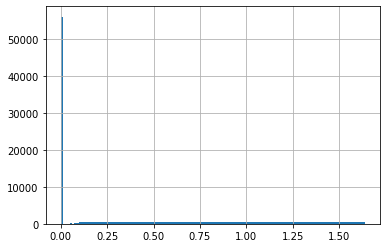

In [193]:
indirim_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.15, pasifik_df_sorted.indirim__.max()+1]
#indirim_bins = [0, 0.009, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, pasifik_df_sorted.indirim__.max()+1]
pasifik_df_sorted.indirim__.hist(bins=indirim_bins)
len(indirim_bins) , pasifik_df_sorted.indirim__.value_counts(bins=indirim_bins).sort_index()
pasifik_df_sorted['indirim__bins'] = pd.cut(pasifik_df_sorted.indirim__, indirim_bins).cat.codes

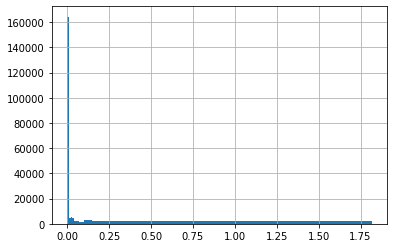

In [194]:
indirim_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.15, horizon_saha_df_sorted.indirim__.max()+1]
horizon_saha_df_sorted.indirim__.hist(bins=indirim_bins)
len(indirim_bins) , horizon_saha_df_sorted.indirim__.value_counts(bins=indirim_bins)
horizon_saha_df_sorted['indirim__bins'] = pd.cut(horizon_saha_df_sorted.indirim__, indirim_bins).cat.codes

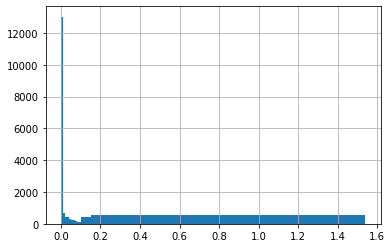

In [195]:
indirim_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.15, btt_df_sorted.indirim__.max()+1]
btt_df_sorted.indirim__.hist(bins=indirim_bins)
len(indirim_bins) , btt_df_sorted.indirim__.value_counts(bins=indirim_bins)
btt_df_sorted['indirim__bins'] = pd.cut(btt_df_sorted.indirim__, indirim_bins).cat.codes

---
# Missing Imputation
---

In [196]:
def missing_imputation(data):
    df_all = []
    data["new_adet"] = data["adet"]
    for sku in data["en_guncel_kod"].unique():
        for grup in data["grup_adi"].unique():
            test = data[(data["en_guncel_kod"] == sku) & (data["grup_adi"] == grup)]
            index_full = list(test[test["new_adet"] != 1].index)
            for idx in range(len(index_full) - 1):
                if index_full[idx+1] - index_full[idx] != 1:
                    index_na = list(range(index_full[idx]+1, index_full[idx+1]))
                    fark = test.loc[index_full[idx+1], "new_adet"] - test.loc[index_full[idx], "new_adet"]
                    bol = len(index_na)
                    ekle = fark/(bol+1)
                    for i in index_na:
                        test.loc[i, "new_adet"] = 0
                        test.loc[i, "new_adet"] += ekle+test.loc[i-1, "new_adet"]
                else:
                    pass
            df_all.append(test)
    df_all = pd.concat(df_all)
    return df_all

In [197]:
pas_backup = pasifik_df_sorted.copy()
hor_backup = horizon_saha_df_sorted.copy()
btt_backup = btt_df_sorted.copy()

In [198]:
start_time = datetime.now()

In [199]:
pasifik_df_sorted = missing_imputation(pasifik_df_sorted)
horizon_saha_df_sorted = missing_imputation(horizon_saha_df_sorted) 
btt_df_sorted = missing_imputation(btt_df_sorted)

In [200]:
end_time = datetime.now()
print('Missing Imputation süresi: {}'.format(end_time - start_time))

Missing Imputation süresi: 0:02:36.432956


In [201]:
pasifik_regression = pasifik_df_sorted.copy()
horizon_regression = horizon_saha_df_sorted.copy()
btt_regression = btt_df_sorted.copy()

In [202]:
pasifik_regression = pasifik_regression[pasifik_regression["new_adet"] != 1].reset_index(drop=True)
horizon_regression = horizon_regression[horizon_regression["new_adet"] != 1].reset_index(drop=True)
btt_regression = btt_regression[btt_regression["new_adet"] != 1].reset_index(drop=True)

In [203]:
def trend_seasonality_decomp(data):
    df_all = []
    for sku in data["en_guncel_kod"].unique():
        for grup in data["grup_adi"].unique():
            temp_df = data[(data["en_guncel_kod"] == sku) & 
                           (data["grup_adi"] == grup)]
            if len(temp_df) > 2:
#                print(sku, grup)
                df_ts = temp_df[['new_adet','date']]
                df_ts.set_index('date',inplace=True)

                result = STL(df_ts).fit()
                temp_df['season'] = list(result.seasonal)
                temp_df['trend']  = list(result.trend)
                temp_df['residual']  = list(result.resid)
                df_all.append(temp_df)
            else:
                pass
    df_all = pd.concat(df_all)
    return df_all

In [204]:
pasifik_df_sorted.sort_values(by=["en_guncel_kod", "grup_adi", "date"], ignore_index=True, inplace=True)
horizon_saha_df_sorted.sort_values(by=["en_guncel_kod", "grup_adi", "date"], ignore_index=True, inplace=True)
btt_df_sorted.sort_values(by=["en_guncel_kod", "grup_adi", "date"], ignore_index=True, inplace=True)

horizon_saha_df_sorted.drop_duplicates(subset=["date", "grup_adi", "en_guncel_kod"], keep="first", ignore_index=True, inplace=True)

In [205]:
pasifik_reg = pasifik_df_sorted[pasifik_df_sorted["scope"] == 3]
horizon_reg = horizon_saha_df_sorted[horizon_saha_df_sorted["scope"] == 3]
btt_reg = btt_df_sorted[btt_df_sorted["scope"] == 3]

In [206]:
start_time = datetime.now()

In [207]:
pasifik_df = trend_seasonality_decomp(pasifik_df_sorted)
horizon_df = trend_seasonality_decomp(horizon_saha_df_sorted)
btt_df = trend_seasonality_decomp(btt_df_sorted)

In [208]:
end_time = datetime.now()
print('Trend Seasonality süresi: {}'.format(end_time - start_time))

Trend Seasonality süresi: 0:02:50.735937


---
# Yeni adet flaglendi
---

In [209]:
pasifik_df["adet_flag"] = np.where(pasifik_df["adet"] - pasifik_df["new_adet"] == 0, 0, 1)
horizon_df["adet_flag"] = np.where(horizon_df["adet"] - horizon_df["new_adet"] == 0, 0, 1)
btt_df["adet_flag"] = np.where(btt_df["adet"] - btt_df["new_adet"] == 0, 0, 1)

In [210]:
pasifik_df_sorted = pasifik_df.copy()
horizon_saha_df_sorted = horizon_df.copy()
btt_df_sorted = btt_df.copy()

In [211]:
horizon_saha_df_sorted["aktivite_tipi"] = np.nan
btt_df_sorted["aktivite_tipi"] = np.nan

In [212]:
pasifik_df_sorted.rename(columns={'i̇ndirimli_raf_satis_fiyati': 'ciro_kull_i̇ade_dus',
                                  'raf_tavsiye_satis_fiyati': 'promosyon_tutari'}, inplace=True)

In [213]:
pasifik_df_sorted["Kanal"] = "pasifik"
horizon_saha_df_sorted["Kanal"] = "horizon"
btt_df_sorted["Kanal"] = "btt"

In [214]:
scope_dict = {0: "kapsam_disi", 1: "ortalama_basilacak", 2: "ts", 3: "regresyon"}

In [215]:
pasifik_df_sorted["scope_type"] = pasifik_df_sorted["scope"].map(scope_dict)
horizon_saha_df_sorted["scope_type"] = horizon_saha_df_sorted["scope"].map(scope_dict)
btt_df_sorted["scope_type"] = btt_df_sorted["scope"].map(scope_dict)

In [216]:
df_all = pd.concat([pasifik_df_sorted, horizon_saha_df_sorted, btt_df_sorted], axis=0, ignore_index=True)

---
# Aktivite Dictionary
---

In [217]:
aktivite_dict = {0:0, 'Mağaza içi/Dağılım':2, 'İn&out':5, 
                 'Çoklu Alım':8, 'Mutluluk':11, 'Kasiyer':14, 'CRM':17}

df_all.aktivite_tipi.fillna(0, inplace=True)
df_all.aktivite_tipi = df_all.aktivite_tipi.map(aktivite_dict)

---
# Datanın dışarıya aktarılması
### Fiyata Göre Sıralanmış Datanın Dışarıya Aktarılması
---

In [218]:
start_time = datetime.now()

In [219]:
df_all = df_all[~((df_all["yil"] == 2021) & (df_all["ay"].isin([6, 7, 8, 9])))]

In [220]:
df_all.to_csv("../data/_all_data_36_12_siparis.csv", index=False)

In [221]:
df_all.to_excel("../data/_all_data_36_12_siparis.xlsx", index=False)

In [222]:
end_time = datetime.now()
print('Datayı dışarıya çıkarma süresi: {}'.format(end_time - start_time))

Datayı dışarıya çıkarma süresi: 0:03:53.831859


# Backup İçin

In [223]:
start_time = datetime.now()

In [224]:
df_all.to_csv("../data/_all_data_36_12_siparis_"+str(datetime.now().month)+str(datetime.now().day)+str(datetime.now().year)+"_"+str(datetime.now().hour)+"_"+str(datetime.now().minute)+".csv", index=False)

In [225]:
df_all.to_excel("../data/_all_data_36_12_siparis"+str(datetime.now().month)+str(datetime.now().day)+str(datetime.now().year)+"_"+str(datetime.now().hour)+"_"+str(datetime.now().minute)+".xlsx", index=False)

In [226]:
end_time = datetime.now()
print('Datayı dışarıya çıkarma süresi: {}'.format(end_time - start_time))

Datayı dışarıya çıkarma süresi: 0:04:28.987126


---
# Datanı altına kombinasyonların eklenmesi

---

In [227]:
data = df_all[(df_all["portfoy"] == 1) & (df_all["scope_type"] != "kapsam_disi")].reset_index(drop=True)
data_backup = data.copy()
sku_list = data.drop_duplicates(subset=["grup_adi", "en_guncel_kod"], keep="first", ignore_index=True)[["grup_adi", "en_guncel_kod", "Kanal"]]

In [228]:
def create_enflasyon(df):
#    month_ = datetime.now().month + 1
#    year_ = datetime.now().year
#    if month_ == 12:
#        month_ = 1
#    else:
#        pass
    month_ = 6
    year_ = 2021
    enflasyon_data = df[(df["date"] >= datetime(year_, month_, 1)-relativedelta(month=2)) & (df["date"] < datetime(year_, month_, 1))]
    enflasyon_data = enflasyon_data[["yil", "ay", "date", "enflasyon_etkisi"]].drop_duplicates(subset=["ay", "yil", "date", "enflasyon_etkisi"], ignore_index=True)
    enflasyon_data = pd.concat([enflasyon_data]*2, ignore_index=True)
    for idx in range(4, len(enflasyon_data)):
        enflasyon_data.loc[idx, "enflasyon_etkisi"] = np.nan
        enflasyon_data.loc[idx, "yil"] = year_
        enflasyon_data.loc[idx, "ay"] = idx+2
        enflasyon_data.loc[idx, "date"] = datetime(year_, idx+2, 1)
    for idx in range(4, len(enflasyon_data)):
        enflasyon_data.loc[idx, "enflasyon_etkisi"] = enflasyon_data.loc[idx-4: idx-1, "enflasyon_etkisi"].mean()
    enf_prev = data[data["date"] < datetime(year_, month_, 1)][["yil", "ay", 
                                                                "date", "enflasyon_etkisi"]].drop_duplicates(subset=["yil", "ay", 
                                                                                                                     "date", "enflasyon_etkisi"]).sort_values(by="date", ignore_index=True)
    enflasyon_final = pd.concat([enf_prev, enflasyon_data.iloc[-4:, :]], axis=0, ignore_index=True)
    return enflasyon_final

In [229]:
enflasyon_data = create_enflasyon(data)

In [230]:
enf_dict_fill = {}
for idx in range(len(enflasyon_data)):
    enf_dict_fill.update({enflasyon_data["date"][idx]: enflasyon_data["enflasyon_etkisi"][idx]})

In [231]:
start_time = datetime.now()

In [232]:
def create_comb(excels):
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    month_ = 5
    year_ = 2021
    pas_s=list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 2, 5, 8, 11, 14, 17]))
    diger_s=list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0]))
    df_all__=[]
    for i in range(len(sku_list)):
        tmp_=excels[(excels["grup_adi"] == sku_list.loc[i, "grup_adi"]) & 
                   (excels["en_guncel_kod"] == sku_list.loc[i, "en_guncel_kod"])]
        new_date = datetime(year_, month_, 1)
        if tmp_['Kanal'].values[0]=='pasifik':
            for trh in range(1, 5):
                new_date_ = new_date + relativedelta(months=trh)
                create_new = pd.DataFrame(tmp_.iloc[-1])
                create_new.loc["yil"] = new_date_.year
                create_new.loc["ay"] = new_date_.month
                create_new.loc["date"] = datetime(new_date_.year, new_date_.month, 1)
                create_new.loc["new_adet"] = np.nan
                create_new.loc["adet"] = np.nan
                create_new.loc["koli"] = np.nan
                create_new.loc["kg"] = np.nan
                create_new.loc["tl"] = np.nan
                create_new.loc["satis_var"] = np.nan
                create_new.loc["enflasyon_etkisi"] = np.nan
                create_new.loc["yarisma"] = np.nan
                create_new.loc["peak"] = 0
                create_new.loc["fiyat"] = np.nan
                create_new.loc["fiyat_gecisi"] = np.nan
                create_new.loc["pandemic"] = 1
                create_new.loc["lockdown"] = 0
                create_new.loc["season"] = np.nan
                create_new.loc["trend"] = np.nan
                tmp = pd.concat([create_new.T]*len(pas_s), ignore_index=True)
                for j in range(len(pas_s)):
                    tmp.loc[j,'indirim__bins'] = pas_s[j][0]
                    tmp.loc[j,'aktivite_tipi'] = pas_s[j][1]
                df_all__.append(tmp)
        else:
            for trh in range(1, 5):
                new_date_ = new_date + relativedelta(months=trh)
                create_new = pd.DataFrame(tmp_.iloc[-1])
                create_new.loc["yil"] = new_date_.year
                create_new.loc["ay"] = new_date_.month
                create_new.loc["date"] = datetime(new_date_.year, new_date_.month, 1)
                create_new.loc["new_adet"] = np.nan
                create_new.loc["adet"] = np.nan
                create_new.loc["koli"] = np.nan
                create_new.loc["kg"] = np.nan
                create_new.loc["tl"] = np.nan
                create_new.loc["satis_var"] = np.nan
                create_new.loc["enflasyon_etkisi"] = np.nan
                create_new.loc["yarisma"] = np.nan
                create_new.loc["peak"] = 0
                create_new.loc["fiyat"] = np.nan
                create_new.loc["fiyat_gecisi"] = np.nan
                create_new.loc["pandemic"] = 1
                create_new.loc["lockdown"] = 0
                create_new.loc["season"] = np.nan
                create_new.loc["trend"] = np.nan
                tmp = pd.concat([create_new.T]*len(diger_s), ignore_index=True)
                for k in range(len(diger_s)):
                    tmp.loc[k,'indirim__bins']=diger_s[k][0]
                    tmp.loc[k,'aktivite_tipi']=diger_s[k][1]
                df_all__.append(tmp)
    df_all__ = pd.concat(df_all__, ignore_index=True)
    return df_all__

In [233]:
all_combinations = create_comb(data)

In [234]:
all_combinations.date.value_counts().sort_index()

2021-06-01    31525
2021-07-01    31525
2021-08-01    31525
2021-09-01    31525
Name: date, dtype: int64

In [235]:
all_combinations = all_combinations[['new_adet', 'yil', 'ay', 'date', 'Kanal', 'grup_adi', 'ana_kategori_adi', 
                                     'kategori_adi', 'marka_adi', 'urun_adi', 'enflasyon_etkisi',  'peak', 'indirim__bins', 
                                     'aktivite_tipi', 'lockdown', 'season', 'trend', 'scope', 'scope_type', 'portfoy']]

all_combinations["enflasyon_etkisi"] = all_combinations["date"].map(enf_dict_fill)
all_combinations["season_iki"] = all_combinations["season"]
all_combinations["season_uc"] = all_combinations["season"]
all_combinations["trend_iki"] = all_combinations["trend"]
all_combinations["trend_uc"] = all_combinations["trend"]

In [236]:
end_time = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_time - start_time))

Kodun çalışma süresi: 0:02:41.115456


In [237]:
start_time = datetime.now()

In [238]:
def create_combination_df(df_):
    """ 
    Tüm kombinasyonlar için bir dictionary içerisinde 91 tane dataframe oluşturuyor. Input olarak aldığı df'in sonuna 3 satır 
    ekleyip indirim__bins ve aktivite_tipi'ni df_indirimbins_aktivitetipi olacak şekilde giriyor. new_adet değişkenine son 3 satır için NA atıyor.  
    """

    indirim_bins_list = ['minus_one','zero','one','two','three','four','five','six','seven','eight','nine','ten','eleven']
    aktivite_tipi_list = ['zero','two','five','eight','eleven','fourteen','seventeen']
    df_names_dict = list(itertools.product(indirim_bins_list, aktivite_tipi_list))

    ind_akt = list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 2, 5, 8, 11, 14, 17]))

    df_names = []
    for idx in df_names_dict:
        df_names.append('df_' + idx[0] + '_' + idx[1])

    df_dict = {}
    for i in range(len(df_names)):
        main_data = data.copy()
        main_data["season_iki"] = main_data["season"]
        main_data["season_uc"] = main_data["season"]
        main_data["trend_iki"] = main_data["trend"]
        main_data["trend_uc"] = main_data["trend"]
        tmp = df_[(df_["aktivite_tipi"] == ind_akt[i][1]) & 
                  (df_["indirim__bins"] == ind_akt[i][0])]

        new_comb_with_main_data = pd.concat([main_data, tmp], ignore_index=True)
        new_comb_with_main_data.sort_values(by=["en_guncel_kod", "grup_adi", "date"], inplace=True, ignore_index=True)
        df_dict[df_names[i]] = new_comb_with_main_data.copy()
    return df_dict

In [239]:
all_combs_df = create_combination_df(all_combinations)

In [240]:
end_time = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_time - start_time))

Kodun çalışma süresi: 0:00:18.795230


In [241]:
time.sleep(5)

In [242]:
conn = swat.CAS('yhtrcl-sasccnt1.yildiz.domain', 5570, username='tunahan.aktas', password='34m153294T...')

In [243]:
start_time = datetime.now()

In [244]:
data_list = list(all_combs_df.keys())

for dfs in data_list:
    tmp = all_combs_df[dfs]
    tmp = tmp[tmp["scope_type"] == "ts"]
    tmp = tmp[["date", "new_adet", "ana_kategori_adi", "grup_adi", "Kanal", "kategori_adi", "marka_adi", "urun_adi", "aktivite_tipi",
               "enflasyon_etkisi", "indirim__bins", "lockdown", "peak", "season", "trend", "season_iki", "season_uc", "trend_iki", "trend_uc"]]
    tmp["enflasyon_etkisi"] = tmp["date"].map(enf_dict_fill)
    tmp["new_adet"] = tmp["new_adet"].astype("float")
    tmp["aktivite_tipi"] = tmp["aktivite_tipi"].astype("float")
    tmp["indirim__bins"] = tmp["indirim__bins"].astype("float")
    tmp["season_iki"] = tmp["season"].astype("float")
    tmp["season_uc"] = tmp["season"].astype("float")
    tmp["trend_iki"] = tmp["trend"].astype("float")
    tmp["trend_uc"] = tmp["trend"].astype("float")
    tmp["lockdown"] = tmp["lockdown"].astype("float")
    tmp["peak"] = tmp["peak"].astype("float")
    tmp["date"] = tmp["date"].apply(lambda x: (x - datetime(1960, 1, 1)).days)
    conn.upload(data=tmp, casout={'caslib':'DSENS_P', 'name':dfs, 'promote':True}, 
                importoptions={'vars':{'date':{'format': 'MMDDYY', "type": "double", "length": 10}}})

NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_ZERO in caslib DSENS_P.
NOTE: The table DF_MINUS_ONE_ZERO has been created in caslib DSENS_P from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_TWO in caslib DSENS_P.
NOTE: The table DF_MINUS_ONE_TWO has been created in caslib DSENS_P from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_FIVE in caslib DSENS_P.
NOTE: The table DF_MINUS_ONE_FIVE has been created in caslib DSENS_P from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_EIGHT in caslib DSENS_P.
NOTE: The table DF_MINUS_ONE_EIGHT has been created in caslib DSENS_P from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table 

In [245]:
output_data_list = [i.replace("df_", "ts_results_") for i in data_list]
input_names = pd.DataFrame({"tables": data_list})
output_names = pd.DataFrame({"tables": output_data_list})

In [246]:
conn.upload(data=input_names, casout={'caslib':'DSENS_P', 'name':'DS_COMB_INPUT_TABLE_NAMES', 'promote':True})
conn.upload(data=output_names, casout={'caslib':'DSENS_P', 'name':'DS_COMB_OUTPUT_TABLE_NAMES', 'promote':True})

NOTE: Cloud Analytic Services made the uploaded file available as table DS_COMB_INPUT_TABLE_NAMES in caslib DSENS_P.
NOTE: The table DS_COMB_INPUT_TABLE_NAMES has been created in caslib DSENS_P from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DS_COMB_OUTPUT_TABLE_NAMES in caslib DSENS_P.
NOTE: The table DS_COMB_OUTPUT_TABLE_NAMES has been created in caslib DSENS_P from binary data uploaded to Cloud Analytic Services.


[caslib]

 'DSENS_P'

[tableName]

 'DS_COMB_OUTPUT_TABLE_NAMES'

[casTable]

 CASTable('DS_COMB_OUTPUT_TABLE_NAMES', caslib='DSENS_P')

+ Elapsed: 0.238s, user: 0.0402s, sys: 0.0686s, mem: 67.1mb

In [247]:
end_time = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_time - start_time))

conn.close()

Kodun çalışma süresi: 0:07:11.729218


In [248]:
end_all_process = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_all_process - start_all_process))

Kodun çalışma süresi: 0:57:47.334996
